In [1]:
#Pipeline - Training binary classifiers to predict mystical experiences 
#This script uses Absolute Power and LZ as input features 

#Import libraries and functions 

import numpy as np 
import pandas as pd 
#For plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Train/test 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
#Eval metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,  precision_recall_fscore_support, make_scorer 
#Models 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
#Feature selection 
from sklearn.feature_selection import RFECV
#Feature importance
import shap 
#save best model 
from joblib import dump
import json
import os
#import homemade functions 
from project_functions import load_data, preprocess_data, feature_selection, plot_rfecv, evaluate_model, plot_cm, shap_analysis, confidence_interval


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#Step 1: Load and process data 
#Load feature matrix 
data = load_data('/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/FeatureExtraction/Relative_and_Absolute/CSV/feature_df_mapped_ARL.csv') 

#Remove 'extra' features in the dataframe and separate into X and Y 

Entropy_columns = [col for col in data.columns if col.startswith('Entropy')] 
LZ_columns = [col for col in data.columns if col.startswith(('LZ', 'HilbertLZ'))] 
relpower = [col for col in data.columns if col.startswith('Rel')]
absopower = [col for col in data.columns if col.startswith('Abso')]

X = data.drop(Entropy_columns + relpower+ ['SubjectID', 'MEQ_Class', 'VRS_Class', 'Anx_Class'], axis = 1) #X contains input features 
y = data['MEQ_Class'] #y contains classification labels 
print("Number of features:", len(X.columns)) #validate 
#Process data - split and scale 
X_train, X_test, y_train, y_test = preprocess_data(X, y, test_size=0.2, random_state=42) #preprocessing steps defined in a function 


Number of features: 256


In [3]:
#Check data shapes before proceed 
validate_shape = {
    'Category ': [
        'Features (x)', 'Labels (y)', 'Train Features (X_train)', 'Test Features (X_test)'
        ],
    'Shape': [ 
        X.shape, y.shape, X_train.shape, X_test.shape
        ]
}
validate_shape_df = pd.DataFrame(validate_shape)
class_distribution = {
    'Class Distribution': [
        'Overall', 'Train', 'Test'
    ],
    'Count':
        [y.value_counts().to_dict(), y_train.value_counts().to_dict(), y_test.value_counts().to_dict()]
}
class_distribution_df = pd.DataFrame(class_distribution)

print('Data Shapes')
print(validate_shape_df)
print('Class Distribtions')
print(class_distribution_df)

Data Shapes
                  Category       Shape
0              Features (x)  (50, 256)
1                Labels (y)      (50,)
2  Train Features (X_train)  (40, 256)
3    Test Features (X_test)  (10, 256)
Class Distribtions
  Class Distribution           Count
0            Overall  {1: 25, 0: 25}
1              Train  {0: 20, 1: 20}
2               Test    {0: 5, 1: 5}


In [ ]:
#Uncomment for imbalanced data 
#from imblearn.over_sampling import SMOTE

## Apply SMOTE to the training data
#smote = SMOTE(random_state=42) #sampling_strategy=0.75)
#X_train, y_train = smote.fit_resample(X_train, y_train) #apply smote to training datasets 

#print('\nTrain Class Distribution:')
#print(y_train.value_counts())

In [4]:
#Step 2: Train default models to establish baseline performance 
rs = 42 #set random state 

#Define models (dictionary)- linear and non linear models considering small dataset, models chosen as also SHAP compatable 
models = {
    "SVM": SVC(kernel= 'linear', probability=True, random_state=rs), #consistent random state 
    "Random_Forest": RandomForestClassifier(random_state=rs),
    "Logistic_Regression": LogisticRegression(random_state=rs),
    "Decision_Tree": DecisionTreeClassifier(random_state=rs),
    "Gradient_Boosting": GradientBoostingClassifier(random_state=rs),
    "Ada_Boosting": AdaBoostClassifier(algorithm='SAMME', random_state=rs),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=rs)
    
}

#set zero division - metric set to zero when the score is undefined - e.g. no positive predictions made by model, does not impact model but how metric is reported
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)
f1 = make_scorer(f1_score, zero_division=0)

#set scoring metrics - dictionary used as variables are defined above 
scoring = {
    'accuracy': 'accuracy',
    'f1': f1,
    'precision': precision,
    'recall': recall,
}

cv = StratifiedKFold(n_splits=5)  

#create dictionary to store results 
results = {
    'Model': [],
    'Accuracy Mean': [],
    'Accuracy Std': [],
    'Accuracy CI Lower':[],
    'Accuracy CI Upper': [],
    'F1 Mean': [],
    'Precision Mean': [],
    'Recall Mean': []
}

#Test default models 
for name, model in models.items(): 
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring) 
    accuracy_scores = cv_results['test_accuracy']
    accuracy_ci_lower, accuracy_ci_upper = confidence_interval(accuracy_scores)

    #append the data for each model to the lists within the dictionary 
    results['Model'].append(name)
    results['Accuracy Mean'].append(cv_results['test_accuracy'].mean())
    results['Accuracy Std'].append(cv_results['test_accuracy'].std())
    results['Accuracy CI Lower'].append(accuracy_ci_lower)
    results['Accuracy CI Upper'].append(accuracy_ci_upper)
    results['F1 Mean'].append(cv_results['test_f1'].mean())
    results['Precision Mean'].append(cv_results['test_precision'].mean())
    results['Recall Mean'].append(cv_results['test_recall'].mean()) 

results_data = pd.DataFrame(results) 

#Save results 

file_path = '/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/RESULTS/MYSTICAL/AbsoLZ/default_models.csv'
results_data.to_csv(file_path, index = False)
results_data


Model  Accuracy Mean  Accuracy Std  Accuracy CI Lower  \
0                  SVM          0.525      0.145774           0.397224   
1        Random_Forest          0.550      0.217945           0.358963   
2  Logistic_Regression          0.425      0.100000           0.337346   
3        Decision_Tree          0.500      0.111803           0.402000   
4    Gradient_Boosting          0.450      0.127475           0.338263   
5         Ada_Boosting          0.525      0.145774           0.397224   
6              XGBoost          0.475      0.165831           0.329643   

   Accuracy CI Upper   F1 Mean  Precision Mean  Recall Mean  
0           0.652776  0.473175        0.463333         0.50  
1           0.741037  0.511905        0.536667         0.50  
2           0.512654  0.390000        0.350000         0.45  
3           0.598000  0.435931        0.400952         0.50  
4           0.561737  0.410476        0.386667         0.45  
5           0.652776  0.428571        0.566667         0.35  
6           0.620357  0.490476        0.533333         0.50

In [5]:
#Step 3: Feature selection for dimensionality reduction 
#RFECV automatically finds the optimal number of features by iterating over different numbers and selecting the one that yields the best cross-validation score
#Best choice when unsure about the optimal number of features and want the method to determine it empirically

feature_names = X.columns

#Initialise dictionaries to store features, selected features and trained models 
selected_features = {}
rfe_data = {} 
trained_models = {}
results_rfe = [] #store results of cv evaluation 


#Loop to conduct RFECV, save optimal feature set and plot on graph 
for name, model in models.items(): 
    print(f"Model: {name}") 
    
    # Perform feature selection using RFECV for models other than RF and DT
    if name in ["Random_Forest", "Decision_Tree"]:
        # Use all features for RF and DT
        X_train_SF = X_train.copy()  # Keep all features
        X_test_SF = X_test.copy()  # Keep all features
        support = None  # No feature selection applied
        optimal_features = X_train_SF.shape[1]  # All features are optimal
                #store reduced feature set for model in dictionary 
        rfe_data[name] = {
            'X_train_SF': X_train_SF,
            'X_test_SF' : X_test_SF
        }
        selected_features[name] = feature_names

    else:
        
        X_train_SF, X_test_SF, support, rfecv, optimal_features = feature_selection(X_train, X_test, y_train, model, cv) #predefined function for feature selection 
        selected_features[name] = feature_names[rfecv.support_].tolist() #filters names of selected features and converts to list to store in selected features dictionary with model name as the key 
        
        #store reduced feature set for model in dictionary 
        rfe_data[name] = {
            'X_train_SF': X_train_SF,
            'X_test_SF' : X_test_SF
        }

        #print optimal number of features 
        print(f"Optimal number of features for {name}: {rfecv.n_features_}")
        print("\n")
        
        #train the model and evaluate the performance of the model on reduced feature set 
        model.fit(X_train_SF, y_train)
        trained_models[name] = model #store trained model in dictionary 
        
        #extract performance metrics on cross validation 
        cv_results_rfe = cross_validate(model, X_train_SF, y_train, cv=cv, scoring=scoring) #eval trained model 
        
        #report selected features and metrics 
        #create dictionary to store results 
        result = {
            'Model' : name, 
            'Optimal number of features' : optimal_features, 
            'Selected features': selected_features[name]
        }
        
        #loop through performance metrics from cv_results_rfe and calculate mean for each metric
        for metric in scoring:
            mean_score = cv_results_rfe[f'test_{metric}'].mean() #cv_results_rfe is a dictionary returned by cross_validate function containing the results of cross validation 
            result[f'CV Mean {metric}'] = mean_score #store mean cv score for metric in dictionary 
        
        results_rfe.append(result)

results_rfe_df = pd.DataFrame(results_rfe)
file_path = '/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/RESULTS/MYSTICAL/AbsoLZ/rfecv_results.csv'
#save results
results_rfe_df.to_csv(file_path, index = False)
results_rfe_df


Model: SVM
Optimal number of features for SVM: 5


Model: Random_Forest
Model: Logistic_Regression
Optimal number of features for Logistic_Regression: 35


Model: Decision_Tree
Model: Gradient_Boosting
Optimal number of features for Gradient_Boosting: 4


Model: Ada_Boosting
Optimal number of features for Ada_Boosting: 15


Model: XGBoost
Optimal number of features for XGBoost: 13




Model  Optimal number of features  \
0                  SVM                           5   
1  Logistic_Regression                          35   
2    Gradient_Boosting                           4   
3         Ada_Boosting                          15   
4              XGBoost                          13   

                                   Selected features  CV Mean accuracy  \
0  [AbsoPowerBetaLow_F3, AbsoPowerBetaHigh_Fz, Ab...             0.775   
1  [AbsoPowerDelta_C3, AbsoPowerDelta_O1, AbsoPow...             0.925   
2  [AbsoPowerDelta_O2, AbsoPowerAlpha_CP2, AbsoPo...             0.725   
3  [AbsoPowerDelta_O2, AbsoPowerDelta_T7, AbsoPow...             0.850   
4  [AbsoPowerDelta_F3, AbsoPowerDelta_O2, AbsoPow...             0.750   

   CV Mean f1  CV Mean precision  CV Mean recall  
0    0.779048           0.786667            0.80  
1    0.927778           0.910000            0.95  
2    0.710000           0.783333            0.75  
3    0.850000           0.850000            0.85  
4    0.695873           0.880000            0.65

In [ ]:
#Step 4: Paramerer optimisation - hyperparameter tuning with random search 
#Define random search grid for each model 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_range = {
"SVM": {
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
        'C': sp_uniform(0.01, 100),  # Use uniform for continuous values
        'degree': sp_randint(1, 10),  # Applicable for 'poly' kernel
        'coef0': sp_uniform(0.0, 1.0)  # Use uniform for continuous values
    }, 
"Random_Forest": {
        'n_estimators': sp_randint(10, 200),
        'max_depth': [None] + list(range(10, 31)),
        'min_samples_split': sp_randint(2, 10),
        'min_samples_leaf': sp_randint(1, 5),
        'bootstrap': [True, False], 
        "criterion": ["gini", "entropy"]
    }, 
"Logistic_Regression": {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Include all penalties - elas not chosen, remove?
    'C': sp_uniform(0.01, 100),  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Choose compatible solvers
    'l1_ratio': sp_uniform(0.0, 1.0),  # Only needed for elasticnet
    'max_iter': [100, 200, 300],  # Increase max_iter if does not converge 
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'class_weight': [None, 'balanced'],  # Handle class imbalance
},
"Decision_Tree": {
        'criterion': ['gini', 'entropy'],  
        'max_depth': [None] + list(range(1, 21)),  
        #'min_samples_split': sp_randint(2, 11),  
        #'min_samples_leaf': sp_randint(1, 11), 
        'class_weight': [None, 'balanced'],  
    },
    
"Gradient_Boosting": {
        'learning_rate': np.linspace(0.01, 0.3, num=20),  # Adjusted upper limit
        'n_estimators': sp_randint(10, 200),  
        'max_depth': sp_randint(3, 10),  
        #'min_samples_split': sp_randint(2, 10), 
        #'min_samples_leaf': sp_randint(1, 10),  
    },
 "Ada_Boosting": {
        'estimator': [None, RandomForestClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()],
        'n_estimators': sp_randint(50, 200),
        'learning_rate': np.linspace(0.01, 2, num=20)
    },
 "XGBoost": { 
        'booster': ['gbtree', 'gblinear'],
        'learning_rate': np.linspace(0.01, 0.3, num=20), 
        'eval_metric': ['rmse', 'mae', 'logloss', 'error'],
        'n_estimators': sp_randint(50, 300),
    }
}

In [7]:
#initialise dictionaries to store best models and scores
best_models = {}
best_params = {}
best_scores = {}
permutation_scores_dict = {}

results = {
    'Model': [],
    'Best Hyperparameters': [],
    'Best Cross-validation Score': [],
    'Mean Test Accuracy': [],
    'SD':[],
    'Mean Test F1': [],
    'Mean Test Precision': [],
    'Mean Test Recall': [],
}

n_iter_dict = {
    "SVM": 40, 
    "Random_Forest": 40, 
    "Logistic_Regression": 40, 
    "Decision_Tree": 40, 
    "Gradient_Boosting": 40, 
    "Ada_Boosting": 40, 
    "XGBoost": 40
}


for name, model in models.items():
    current_param_range = param_range[name] #extract parameter grid for model from predefined dictionary 
    X_train = rfe_data[name]['X_train_SF']
    
    rand_search = RandomizedSearchCV(
        estimator = model, 
        param_distributions=current_param_range, 
        n_iter=n_iter_dict[name], 
        cv=cv, 
        scoring = scoring, 
        refit = 'f1',
        return_train_score=True) 
    rand_search.fit(X_train, y_train) #fit model with grid search and X_train containing optimal number of features 
    
    best_models[name] = rand_search.best_estimator_ #store best model 
    best_params[name] = rand_search.best_params_ #store best hyperparamters for model 
    best_scores[name] = rand_search.best_score_ #store best cv score for model 
    
    print(f"Model: {name}") #debug 
    
    cv_results = rand_search.cv_results_
    mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][rand_search.best_index_] for metric in scoring}
    
    std_test_accuracy = cv_results['std_test_accuracy'][rand_search.best_index_]  # Get standard deviation of accuracy scores
    
    results['Model'].append(name)
    results['Best Hyperparameters'].append(best_params[name])
    results['Best Cross-validation Score'].append(best_scores[name])
    results['Mean Test Accuracy'].append(mean_test_scores['accuracy'])
    results['SD'].append(std_test_accuracy)
    results['Mean Test F1'].append(mean_test_scores['f1'])
    results['Mean Test Precision'].append(mean_test_scores['precision'])
    results['Mean Test Recall'].append(mean_test_scores['recall'])

results_hpt_df = pd.DataFrame(results)
file_path = '/Volumes/Harddrive/Paper_followup/Results/Mystical_Experiences/rand_search_results.csv'
#save results 
results_hpt_df.to_csv(file_path, index=False)
results_hpt_df


Model: SVM
Model: Random_Forest


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge

Model: Logistic_Regression
Model: Decision_Tree
Model: Gradient_Boosting
Model: Ada_Boosting
Model: XGBoost


Model                               Best Hyperparameters  \
0                  SVM  {'C': 0.8453302527600692, 'coef0': 0.338405845...   
1        Random_Forest  {'bootstrap': False, 'criterion': 'gini', 'max...   
2  Logistic_Regression  {'C': 87.056286873323, 'class_weight': 'balanc...   
3        Decision_Tree  {'max_depth': 2, 'criterion': 'entropy', 'clas...   
4    Gradient_Boosting  {'learning_rate': 0.2847368421052632, 'max_dep...   
5         Ada_Boosting  {'estimator': None, 'learning_rate': 0.6384210...   
6              XGBoost  {'booster': 'gbtree', 'eval_metric': 'mae', 'l...   

   Best Cross-validation Score  Mean Test Accuracy        SD  Mean Test F1  \
0                     0.783492               0.775  0.093541      0.783492   
1                     0.578571               0.600  0.183712      0.578571   
2                     0.949206               0.950  0.061237      0.949206   
3                     0.466032               0.500  0.209165      0.466032   
4                     0.779206               0.825  0.127475      0.779206   
5                     0.850000               0.850  0.122474      0.850000   
6                     0.802597               0.800  0.150000      0.802597   

   Mean Test Precision  Mean Test Recall  
0             0.760000              0.85  
1             0.616667              0.55  
2             0.960000              0.95  
3             0.413333              0.55  
4             0.910000              0.75  
5             0.850000              0.85  
6             0.847619              0.80

In [8]:
#Step 5: Test on unseen data 
#create dictionary for test results to convert into df 
test_results = {
   'Model' : [],
   'Test_accuracy':[],
   'Test_f1': [],
   'Test_precision':[],
   'Test_recall':[],
   'Confusion_matrix':[],

}

class_names = ['Non-Mystical', 'Mystical']
savedir = '/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/RESULTS/MYSTICAL/AbsoLZ/CMs/'

for name, model in best_models.items():
   #Retrieve test set with selected features for specific model
    X_test = rfe_data[name]['X_test_SF']
    print(f'Model: {name}')
    accuracy, f1, precision, recall, cm = evaluate_model(model, X_test, y_test)
    plot_cm(cm, class_names = class_names, name = name, savedir = savedir)
    
    #add to test data dictionary 
    test_results['Model'].append(name)
    test_results['Test_accuracy'].append(accuracy)

    test_results['Test_f1'].append(f1)
    test_results['Test_precision'].append(precision)
    test_results['Test_recall'].append(recall)
    test_results['Confusion_matrix'].append(cm)
    
test_results_df = pd.DataFrame(test_results)

file_path = '/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/RESULTS/MYSTICAL/AbsoLZ/test_results.csv'
#save 
test_results_df.to_csv(file_path, index=False)
test_results_df


Model: SVM
Model: Random_Forest
Model: Logistic_Regression
Model: Decision_Tree
Model: Gradient_Boosting
Model: Ada_Boosting
Model: XGBoost


Model  Test_accuracy   Test_f1  Test_precision  Test_recall  \
0                  SVM            0.4  0.400000        0.400000          0.4   
1        Random_Forest            0.6  0.600000        0.600000          0.6   
2  Logistic_Regression            0.5  0.545455        0.500000          0.6   
3        Decision_Tree            0.4  0.500000        0.428571          0.6   
4    Gradient_Boosting            0.9  0.909091        0.833333          1.0   
5         Ada_Boosting            0.6  0.600000        0.600000          0.6   
6              XGBoost            0.8  0.800000        0.800000          0.8   

   Confusion_matrix  
0  [[2, 3], [3, 2]]  
1  [[3, 2], [2, 3]]  
2  [[2, 3], [2, 3]]  
3  [[1, 4], [2, 3]]  
4  [[4, 1], [0, 5]]  
5  [[3, 2], [2, 3]]  
6  [[4, 1], [1, 4]]

Model: SVM
Selected features: ['AbsoPowerBetaLow_F3', 'AbsoPowerBetaHigh_Fz', 'AbsoPowerBetaHigh_POz', 'HilbertLZ_P3', 'HilbertLZ_O1']
X_train_rfe shape: (40, 5)
X_test_rfe shape: (10, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Model: Random_Forest
Selected features: Index(['AbsoPowerDelta_Fp1', 'AbsoPowerDelta_Fp2', 'AbsoPowerDelta_F3',
       'AbsoPowerDelta_F4', 'AbsoPowerDelta_C3', 'AbsoPowerDelta_C4',
       'AbsoPowerDelta_P3', 'AbsoPowerDelta_P4', 'AbsoPowerDelta_O1',
       'AbsoPowerDelta_O2',
       ...
       'HilbertLZ_CP1', 'HilbertLZ_CP2', 'HilbertLZ_FC5', 'HilbertLZ_FC6',
       'HilbertLZ_CP5', 'HilbertLZ_CP6', 'HilbertLZ_TP9', 'HilbertLZ_TP10',
       'HilbertLZ_POz', 'HilbertLZ_FCz'],
      dtype='object', length=256)
X_train_rfe shape: (40, 256)
X_test_rfe shape: (10, 256)
Model: Logistic_Regression
Selected features: ['AbsoPowerDelta_C3', 'AbsoPowerDelta_O1', 'AbsoPowerDelta_F7', 'AbsoPowerDelta_FC2', 'AbsoPowerDelta_FC5', 'AbsoPowerDelta_TP9', 'AbsoPowerTheta_F3', 'AbsoPowerTheta_P7', 'AbsoPowerTheta_Fz', 'AbsoPowerTheta_Oz', 'AbsoPowerTheta_FC2', 'AbsoPowerTheta_TP9', 'AbsoPowerTheta_POz', 'AbsoPowerAlpha_O1', 'AbsoPowerAlpha_T8', 'AbsoPowerBetaLow_F3', 'AbsoPowerBetaLow_P4', 'AbsoPowerB

  0%|          | 0/10 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Model: Decision_Tree
Selected features: Index(['AbsoPowerDelta_Fp1', 'AbsoPowerDelta_Fp2', 'AbsoPowerDelta_F3',
       'AbsoPowerDelta_F4', 'AbsoPowerDelta_C3', 'AbsoPowerDelta_C4',
       'AbsoPowerDelta_P3', 'AbsoPowerDelta_P4', 'AbsoPowerDelta_O1',
       'AbsoPowerDelta_O2',
       ...
       'HilbertLZ_CP1', 'HilbertLZ_CP2', 'HilbertLZ_FC5', 'HilbertLZ_FC6',
       'HilbertLZ_CP5', 'HilbertLZ_CP6', 'HilbertLZ_TP9', 'HilbertLZ_TP10',
       'HilbertLZ_POz', 'HilbertLZ_FCz'],
      dtype='object', length=256)
X_train_rfe shape: (40, 256)
X_test_rfe shape: (10, 256)


  0%|          | 0/10 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Model: Gradient_Boosting
Selected features: ['AbsoPowerDelta_O2', 'AbsoPowerAlpha_CP2', 'AbsoPowerGamma_FC1', 'AbsoPowerGamma_FCz']
X_train_rfe shape: (40, 4)
X_test_rfe shape: (10, 4)
Model: Ada_Boosting
Selected features: ['AbsoPowerDelta_O2', 'AbsoPowerDelta_T7', 'AbsoPowerDelta_Pz', 'AbsoPowerTheta_Fp1', 'AbsoPowerTheta_FC2', 'AbsoPowerBetaHigh_F7', 'AbsoPowerBetaHigh_CP6', 'AbsoPowerBetaHigh_POz', 'AbsoPowerGamma_Fp1', 'AbsoPowerGamma_T8', 'AbsoPowerGamma_FCz', 'LZ_C4', 'LZ_Oz', 'HilbertLZ_F3', 'HilbertLZ_Oz']
X_train_rfe shape: (40, 15)
X_test_rfe shape: (10, 15)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


  0%|          | 0/10 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Model: XGBoost
Selected features: ['AbsoPowerDelta_F3', 'AbsoPowerDelta_O2', 'AbsoPowerTheta_Fp1', 'AbsoPowerTheta_FC2', 'AbsoPowerTheta_CP6', 'AbsoPowerAlpha_P4', 'AbsoPowerBetaHigh_C3', 'AbsoPowerBetaHigh_FCz', 'AbsoPowerGamma_FC1', 'AbsoPowerGamma_FCz', 'LZ_C4', 'LZ_O2', 'HilbertLZ_FC5']
X_train_rfe shape: (40, 13)
X_test_rfe shape: (10, 13)


[13:26:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


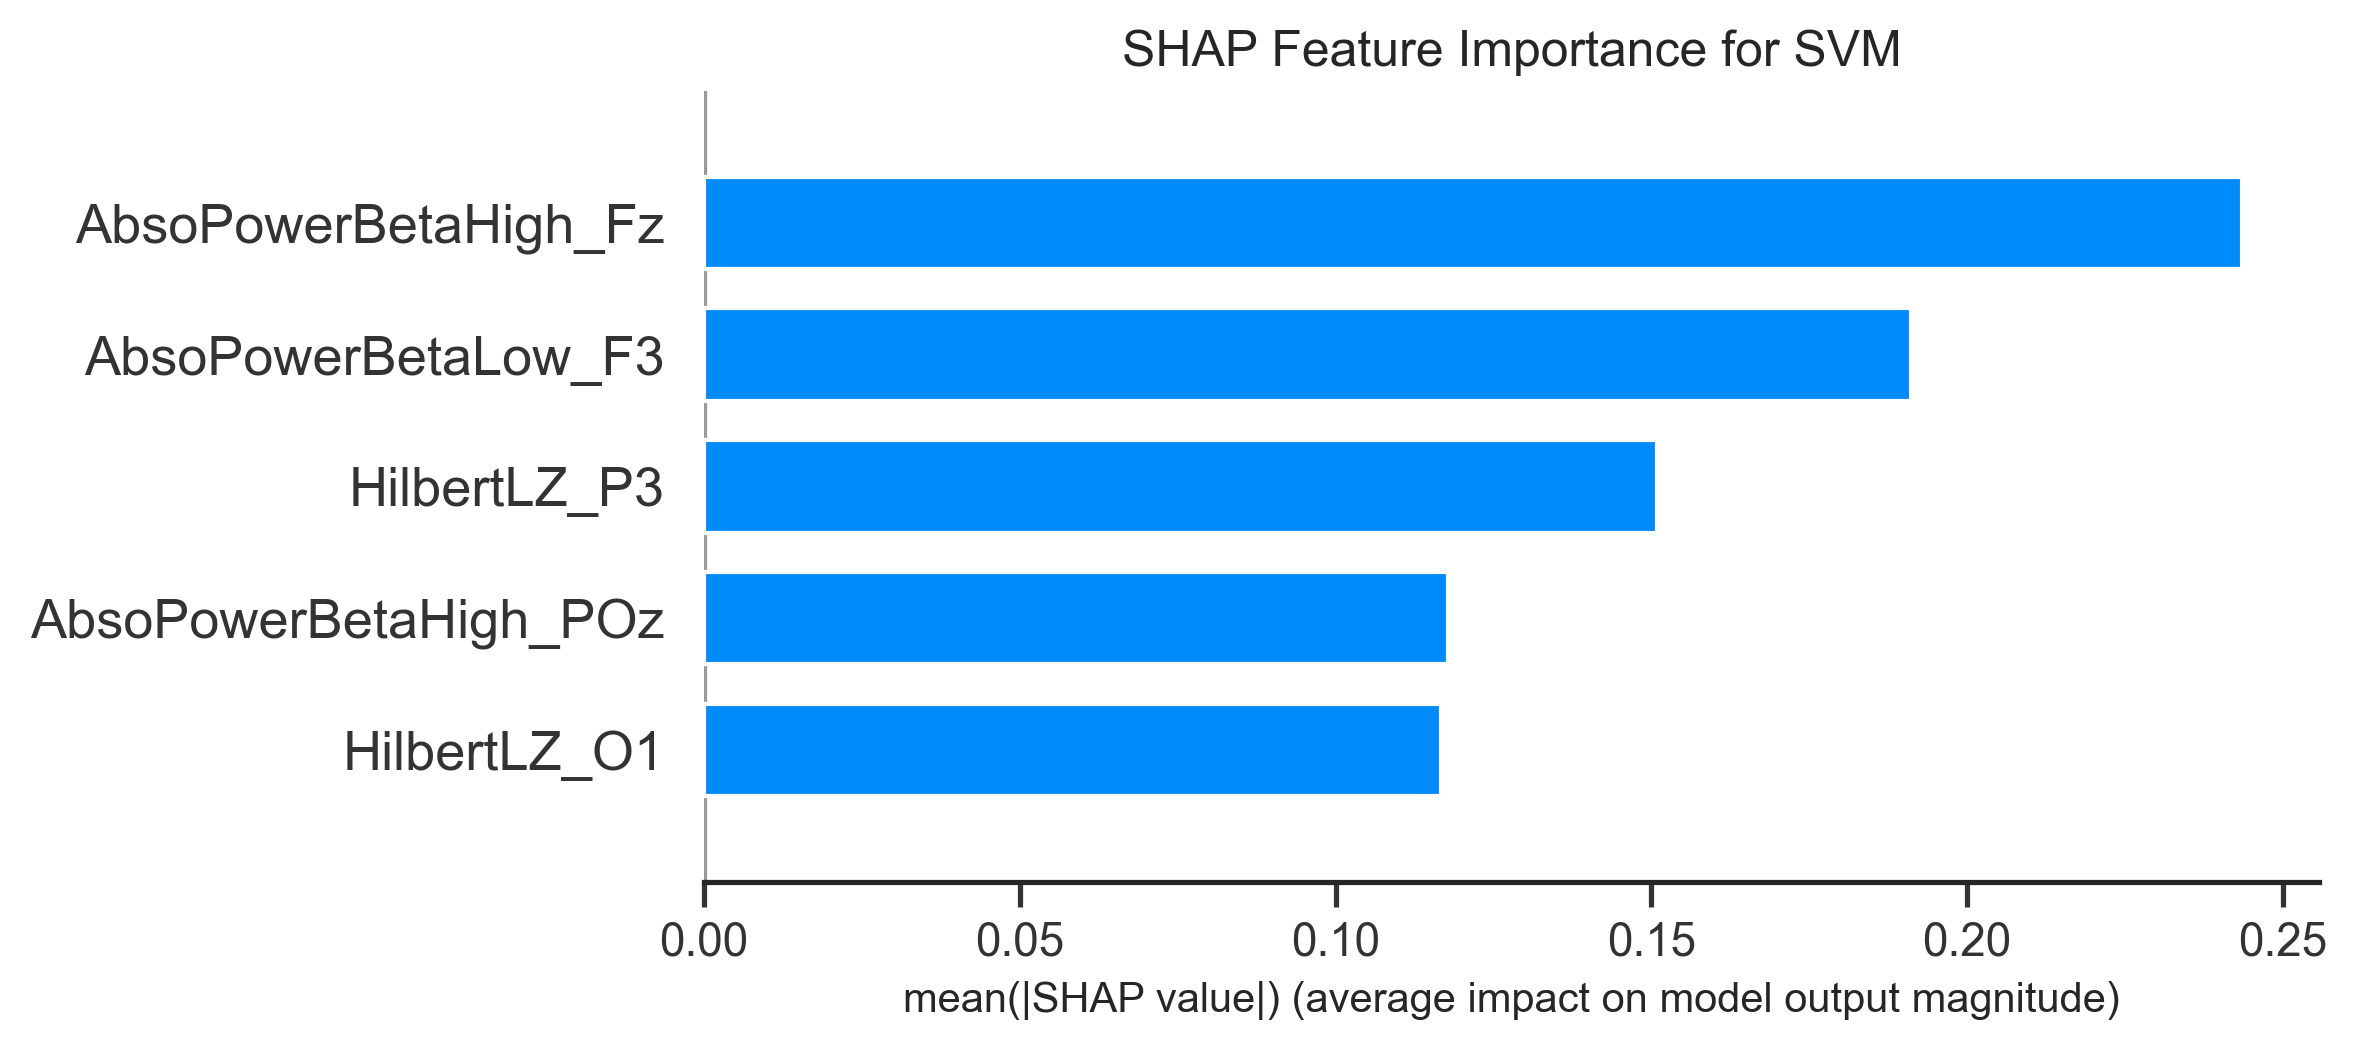

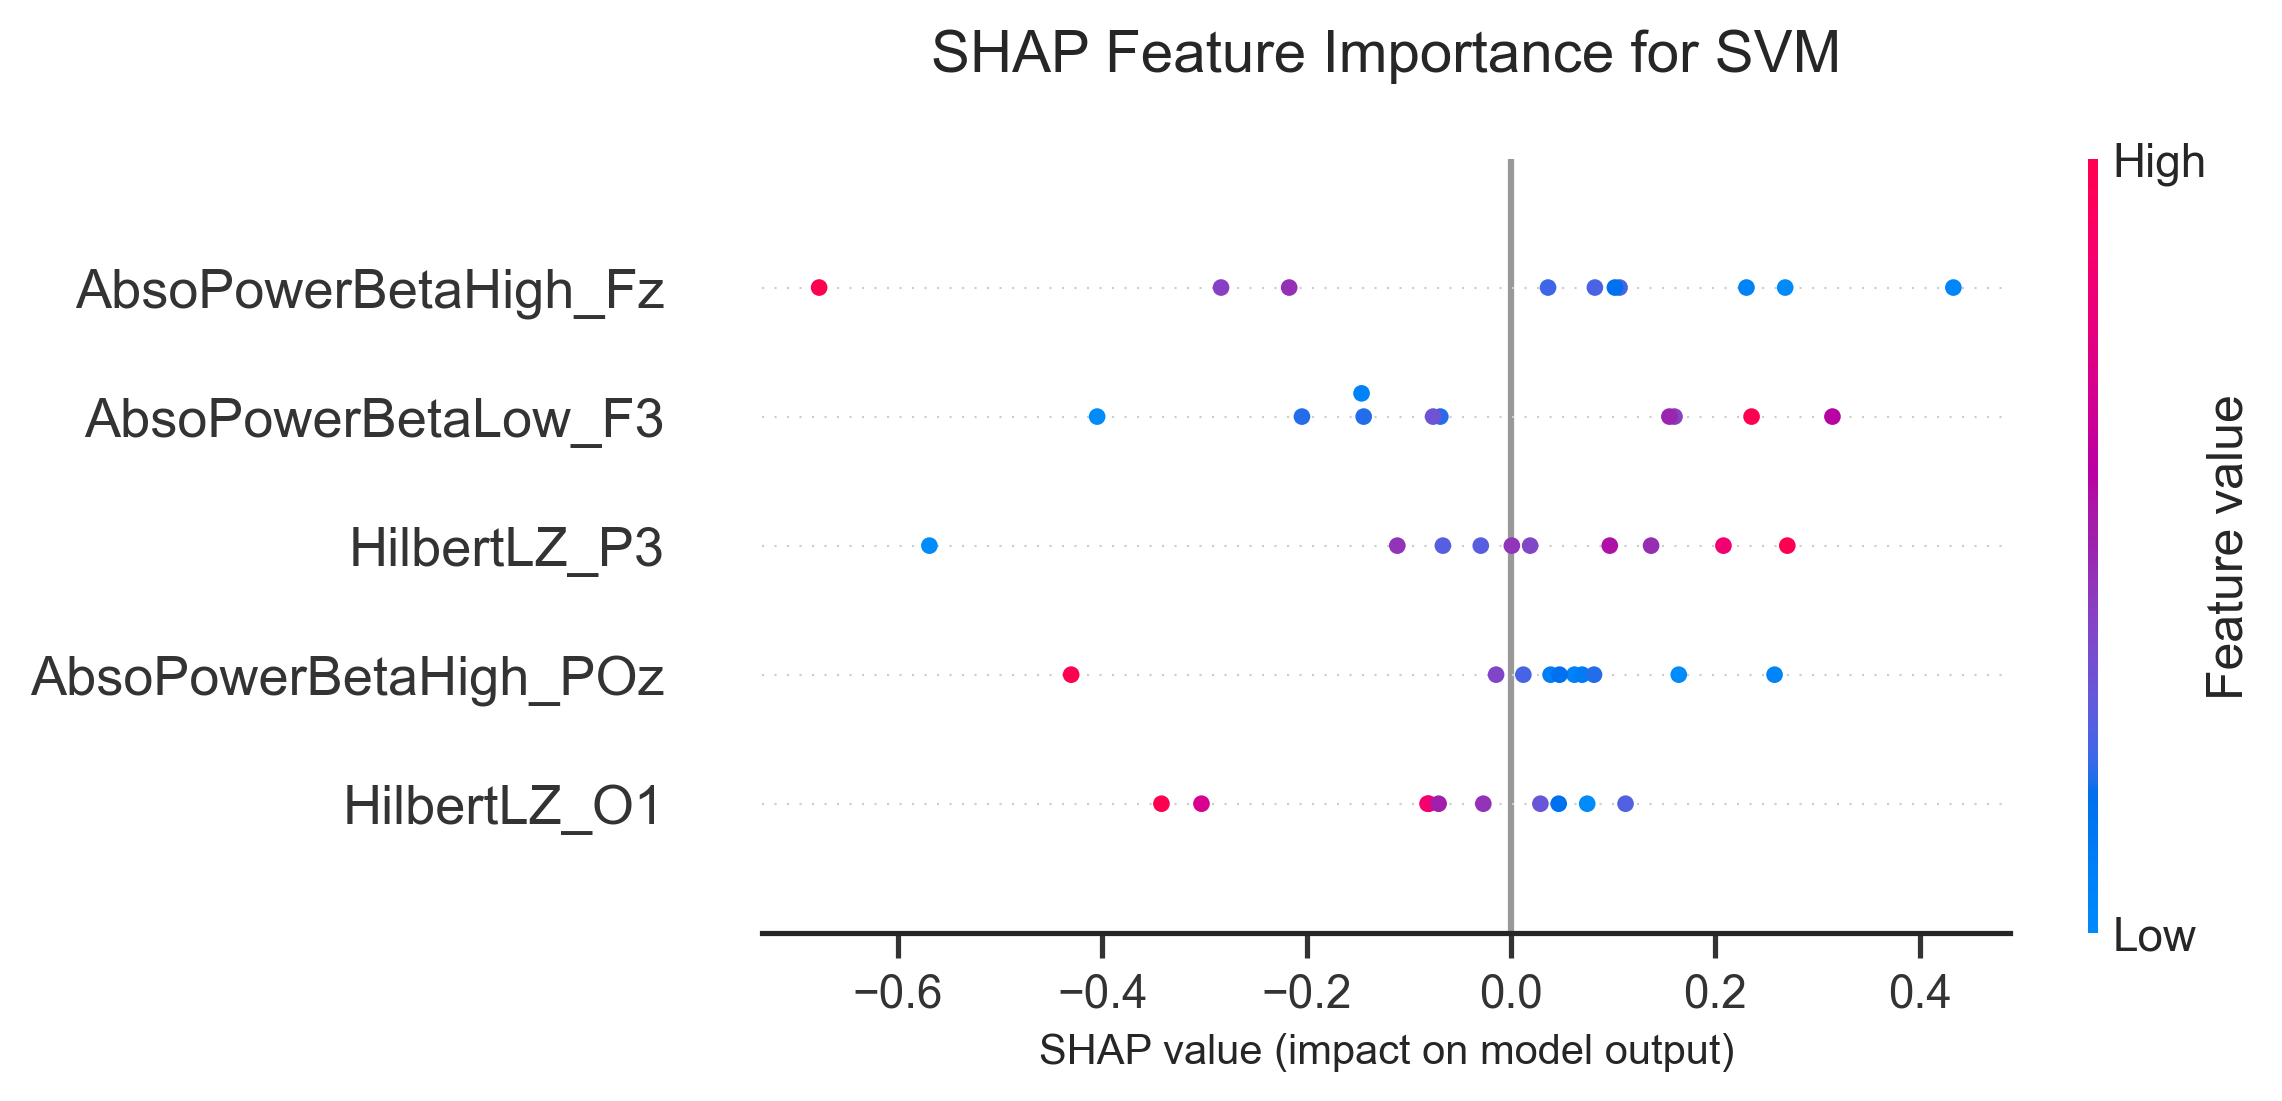

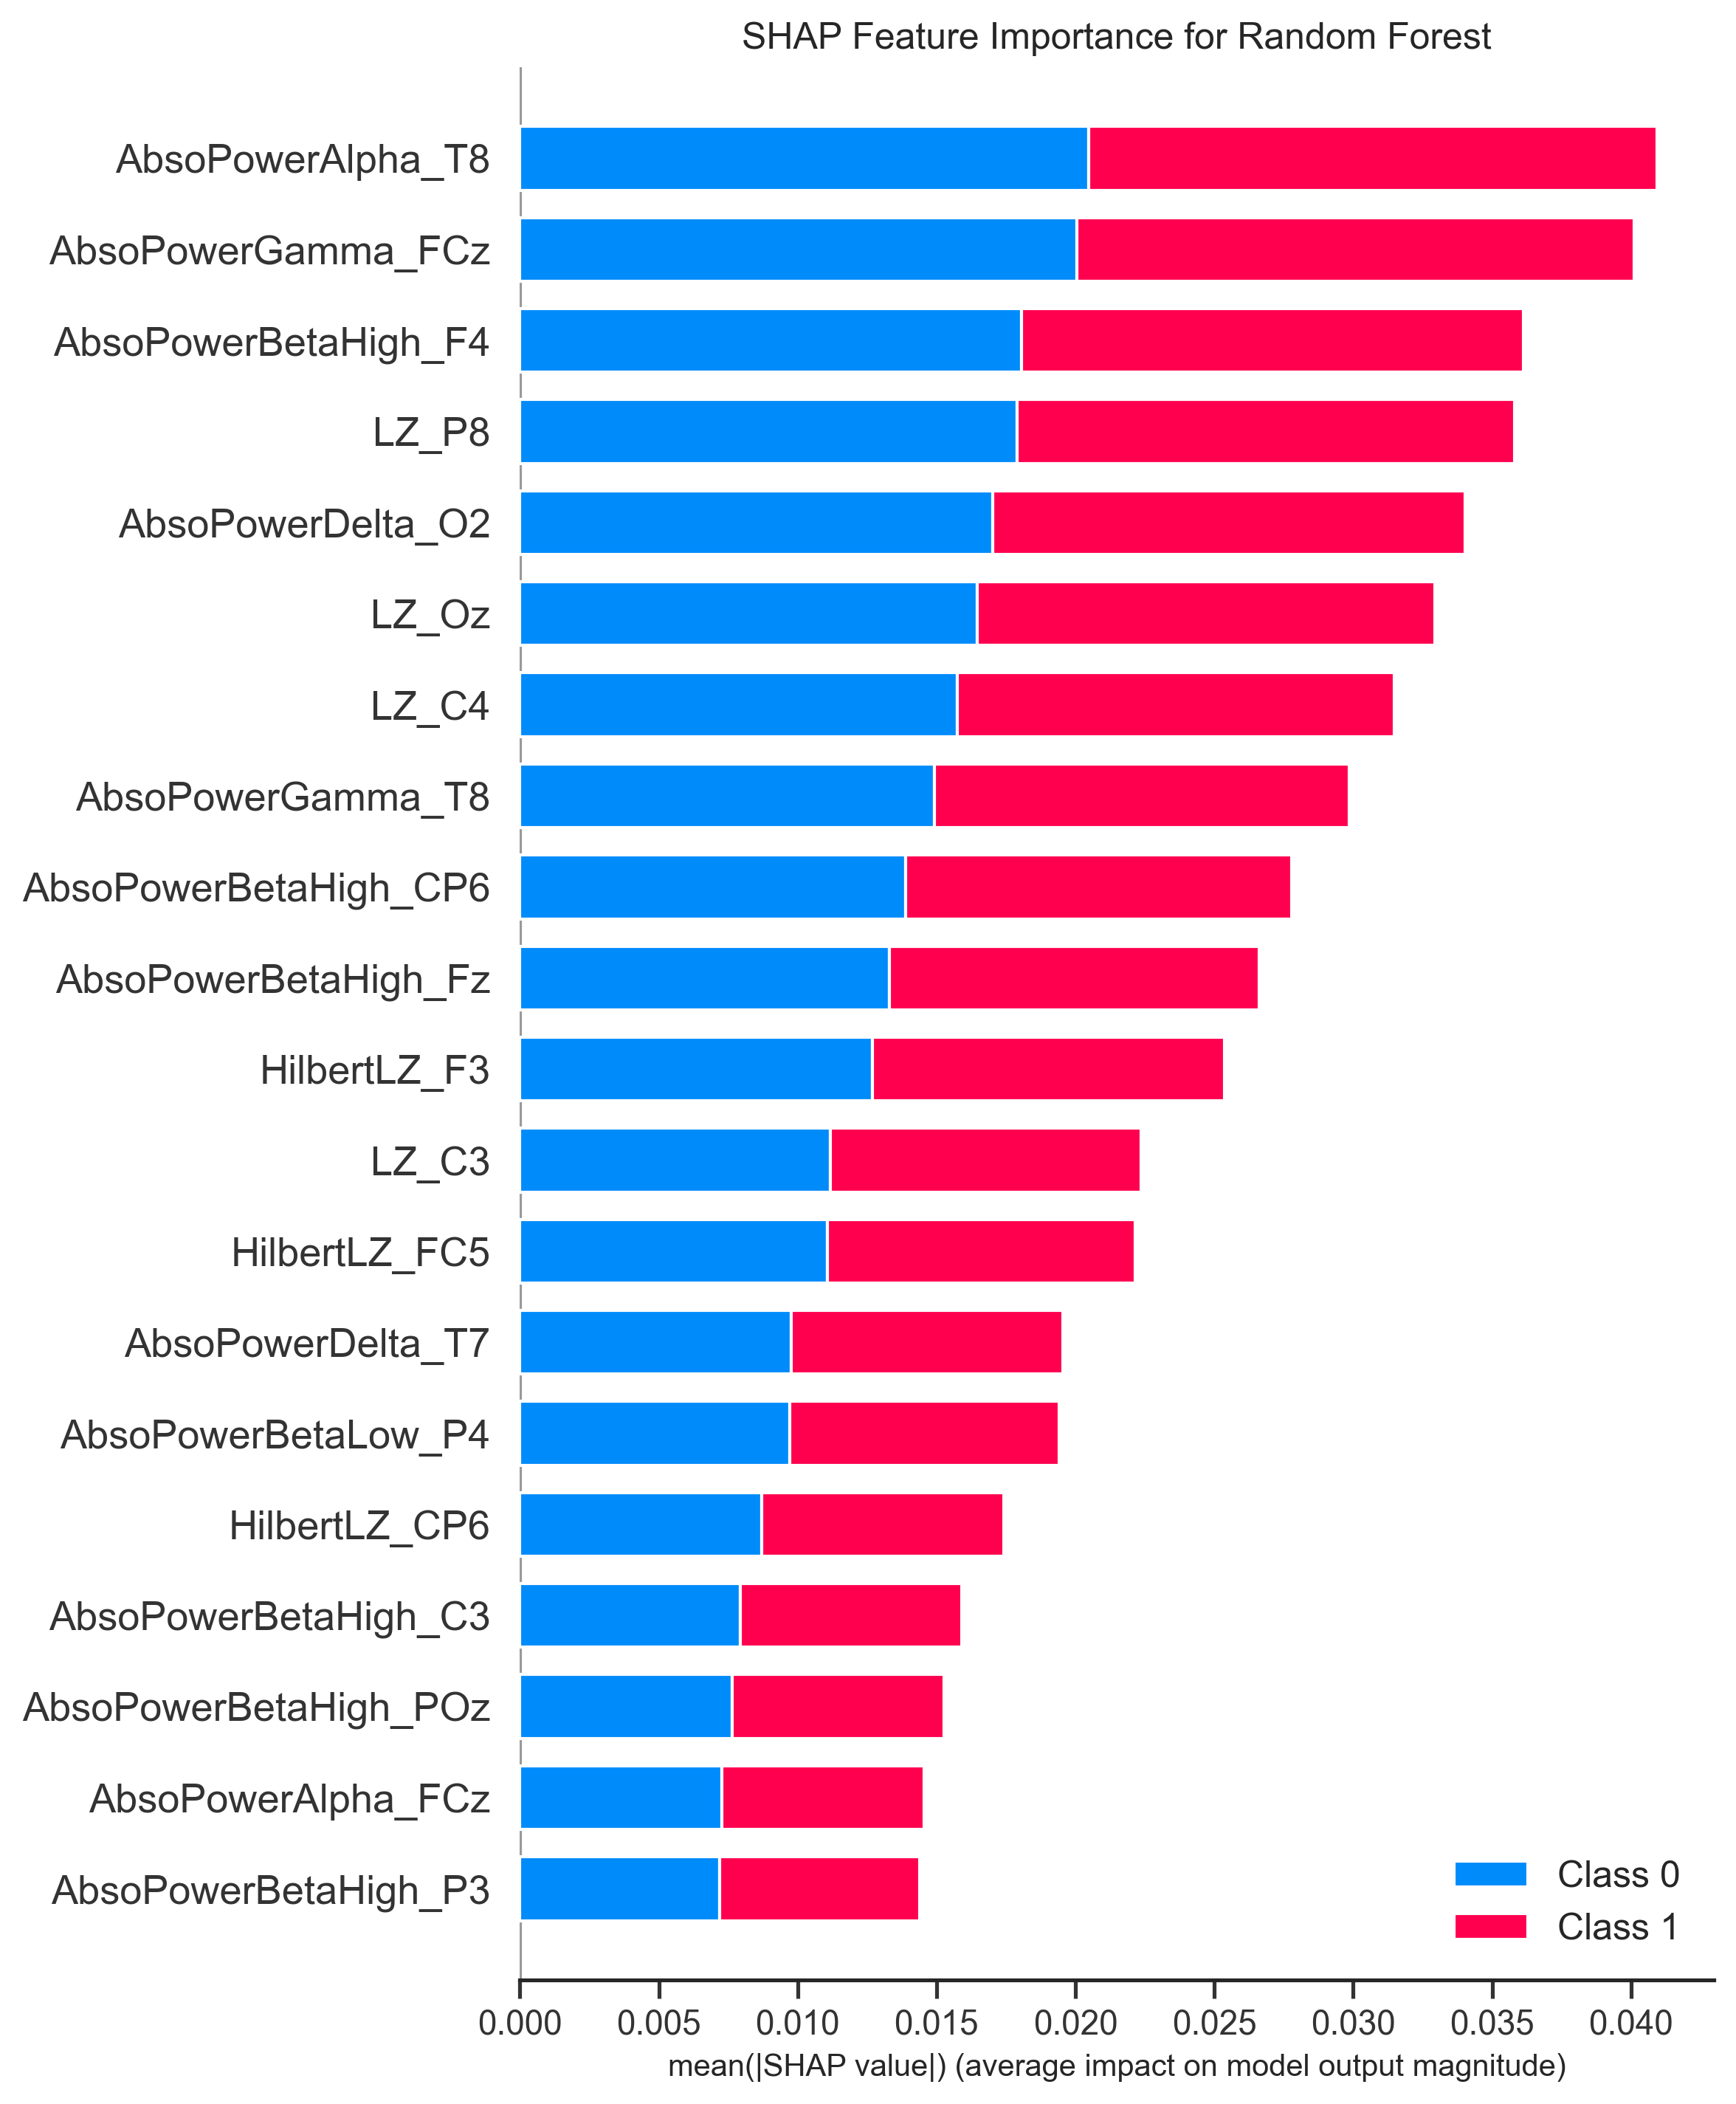

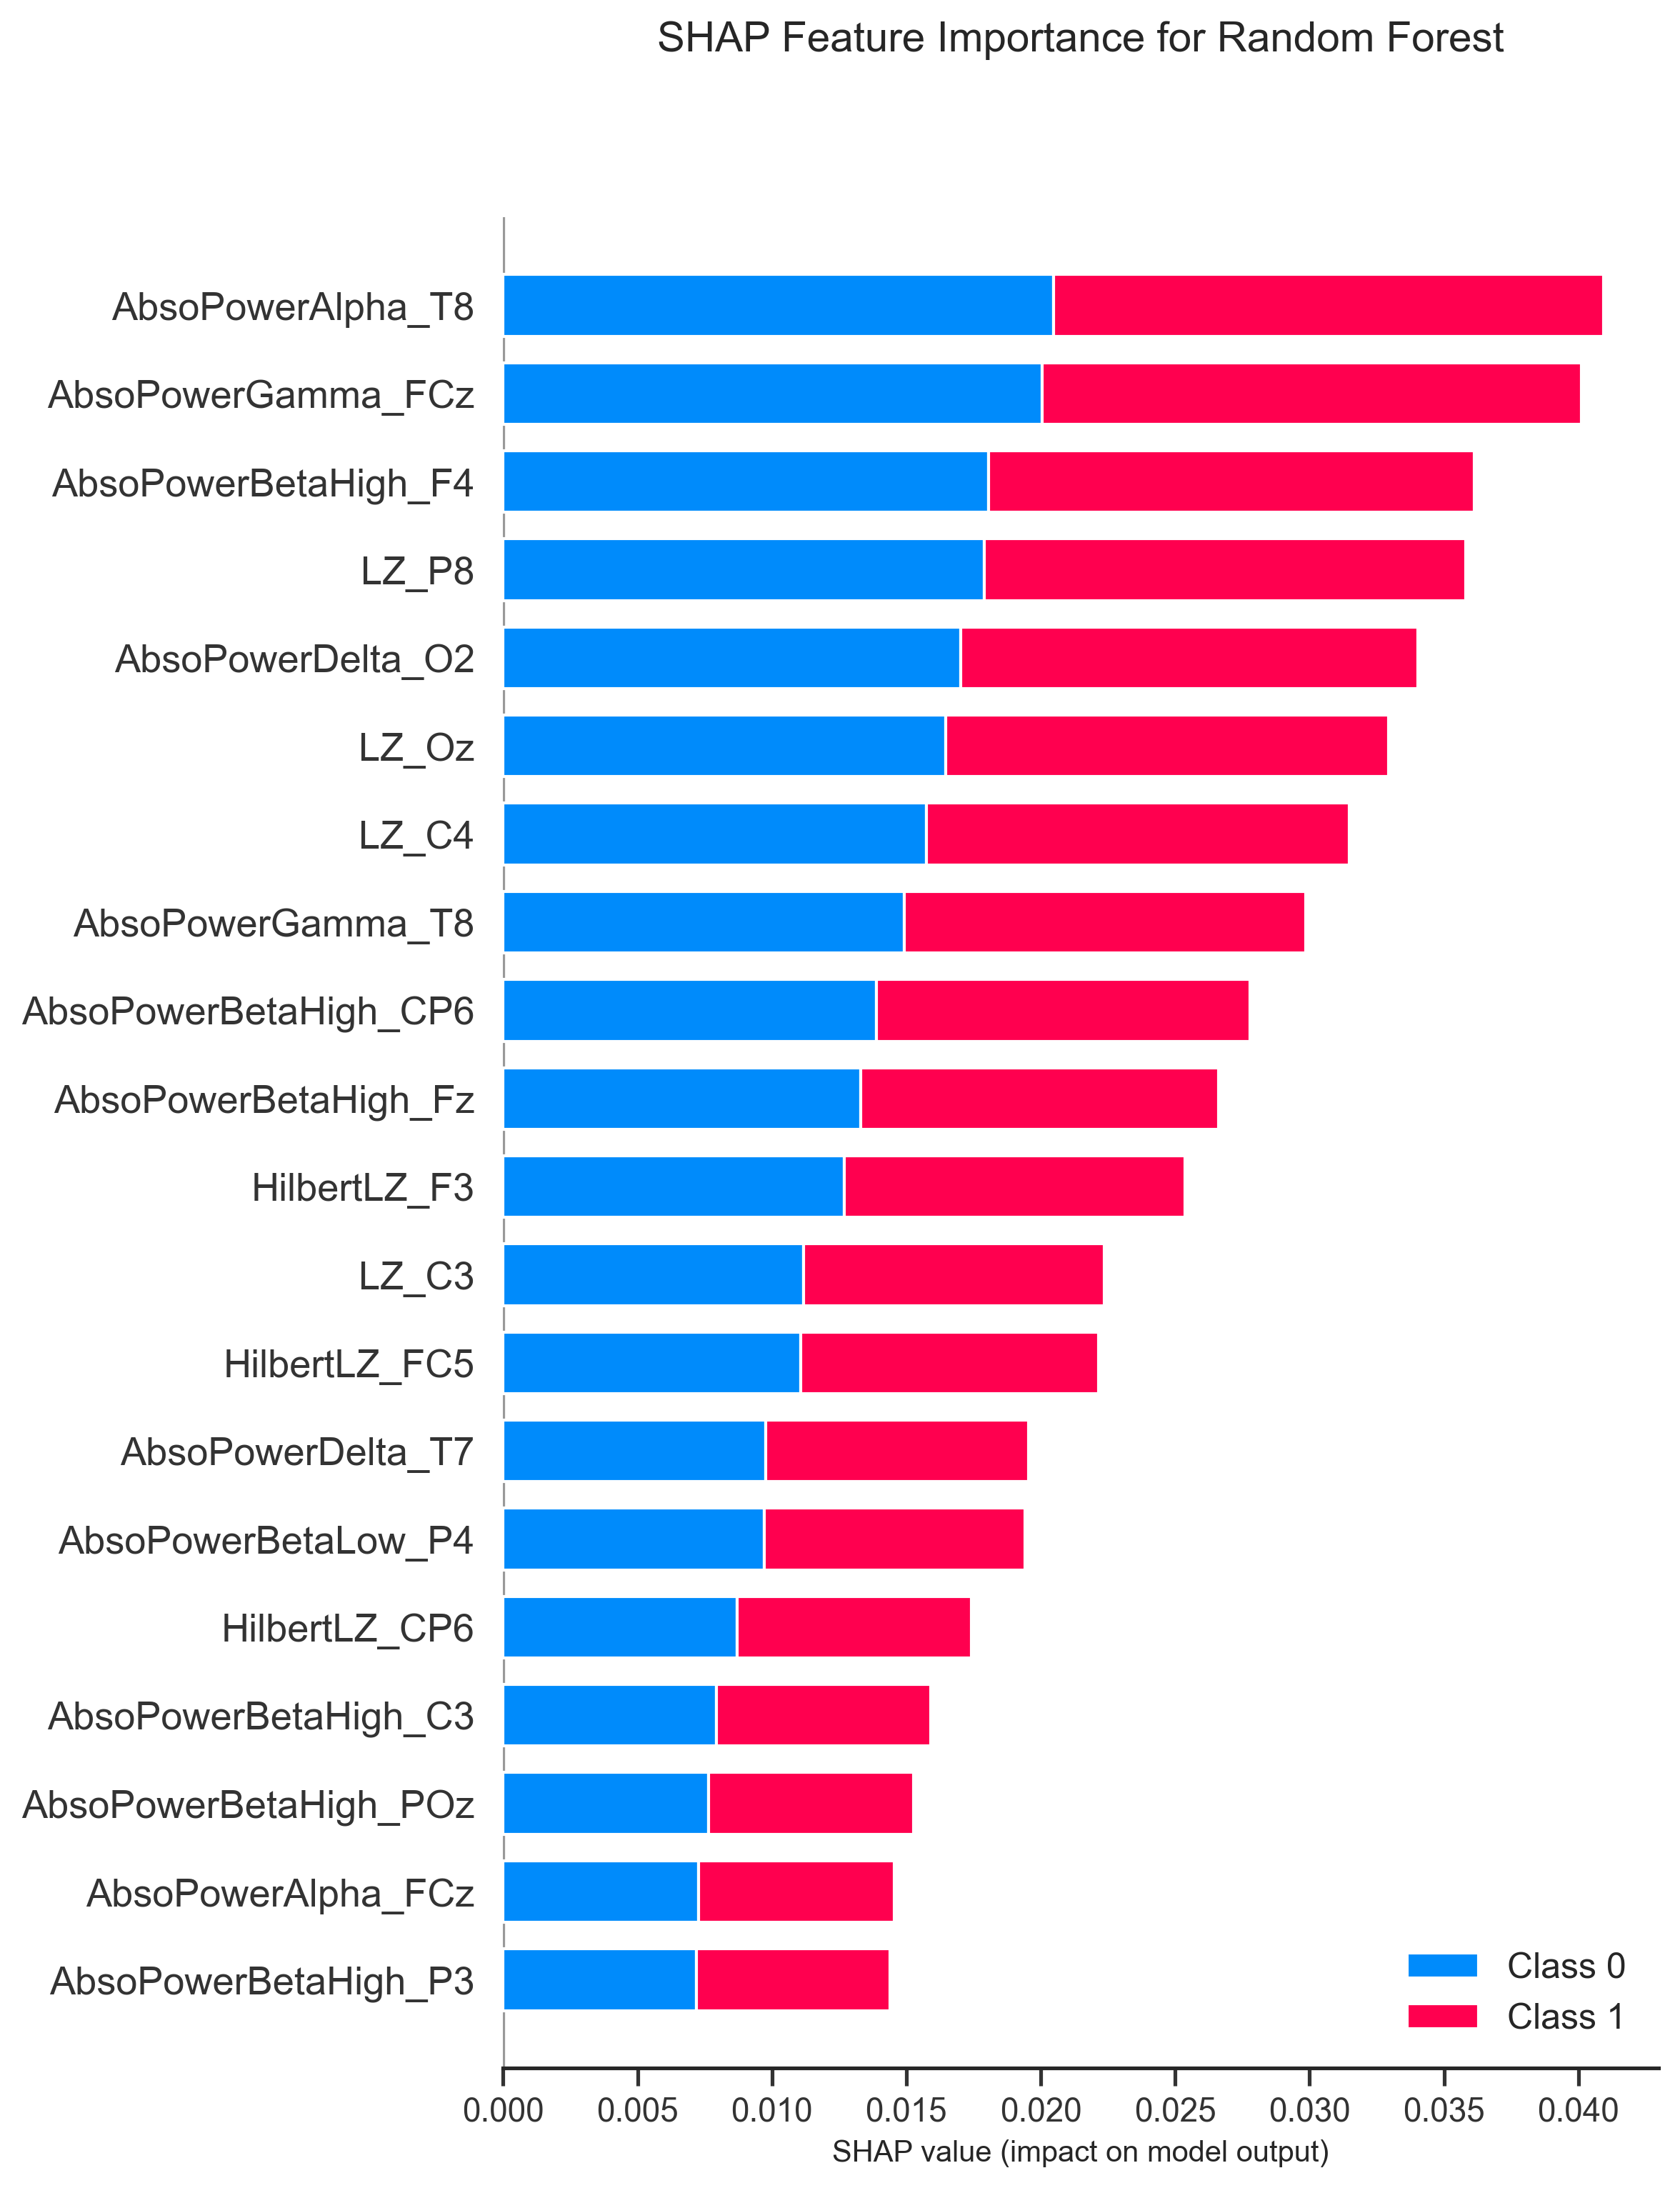

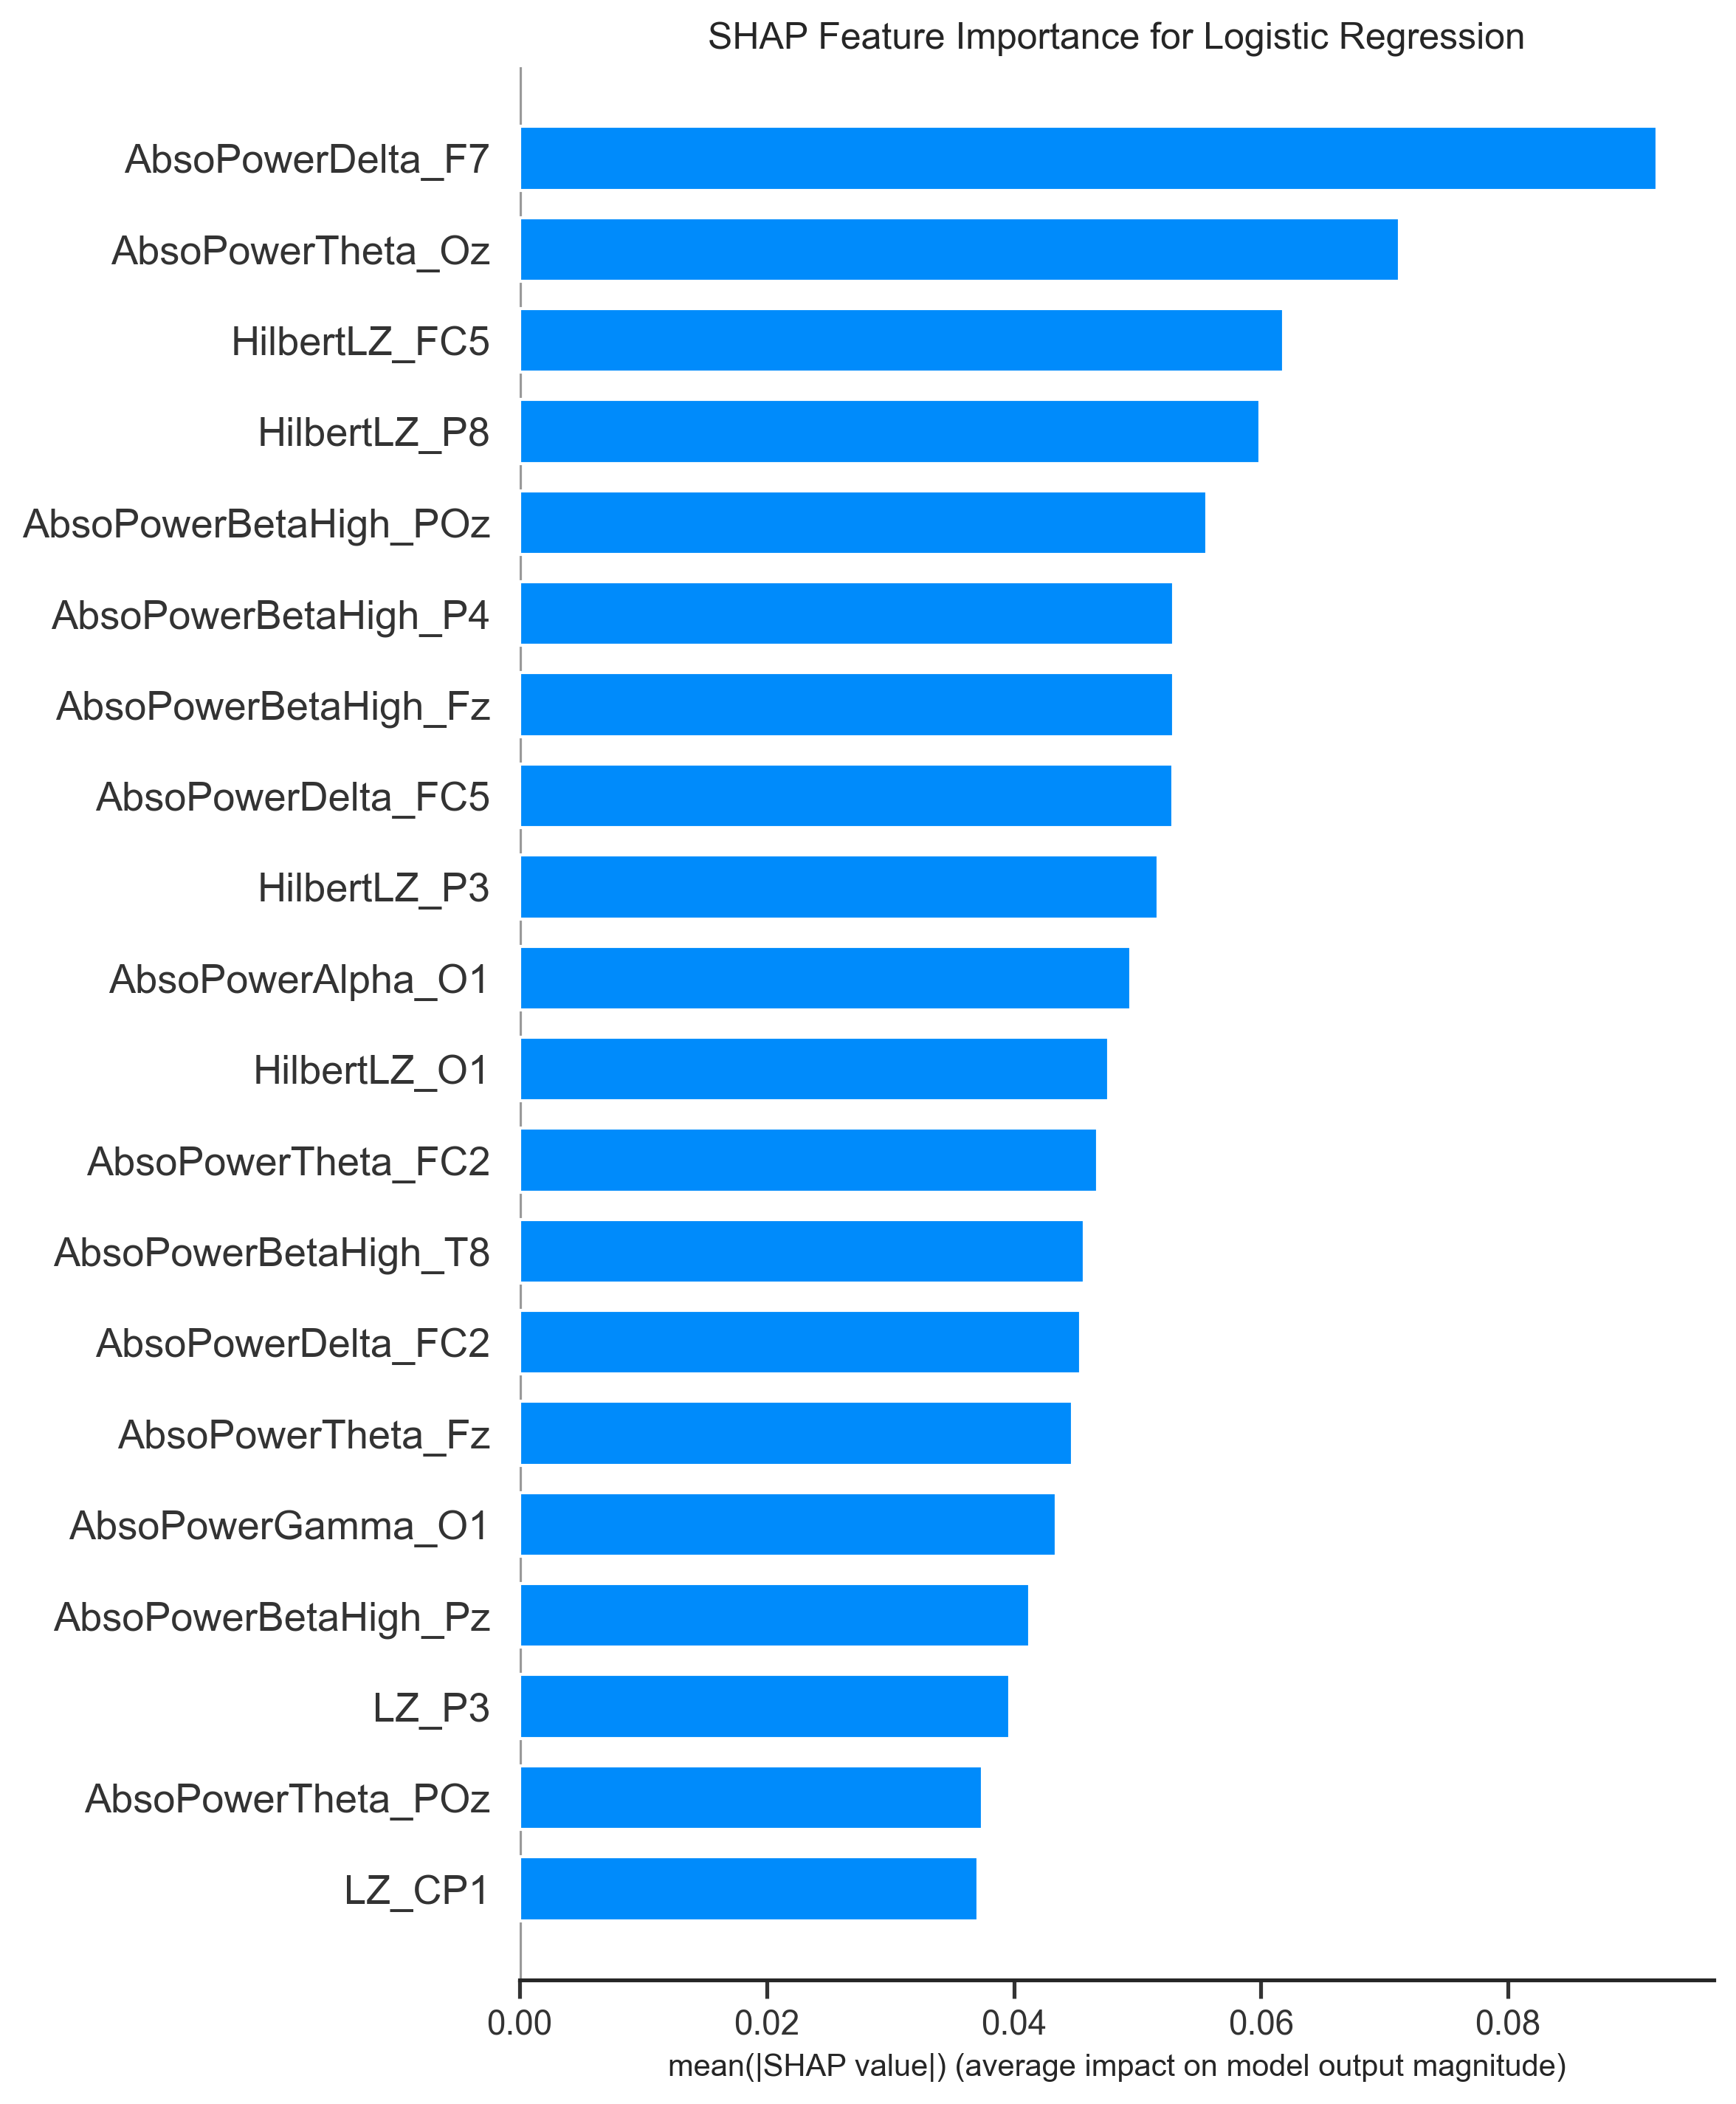

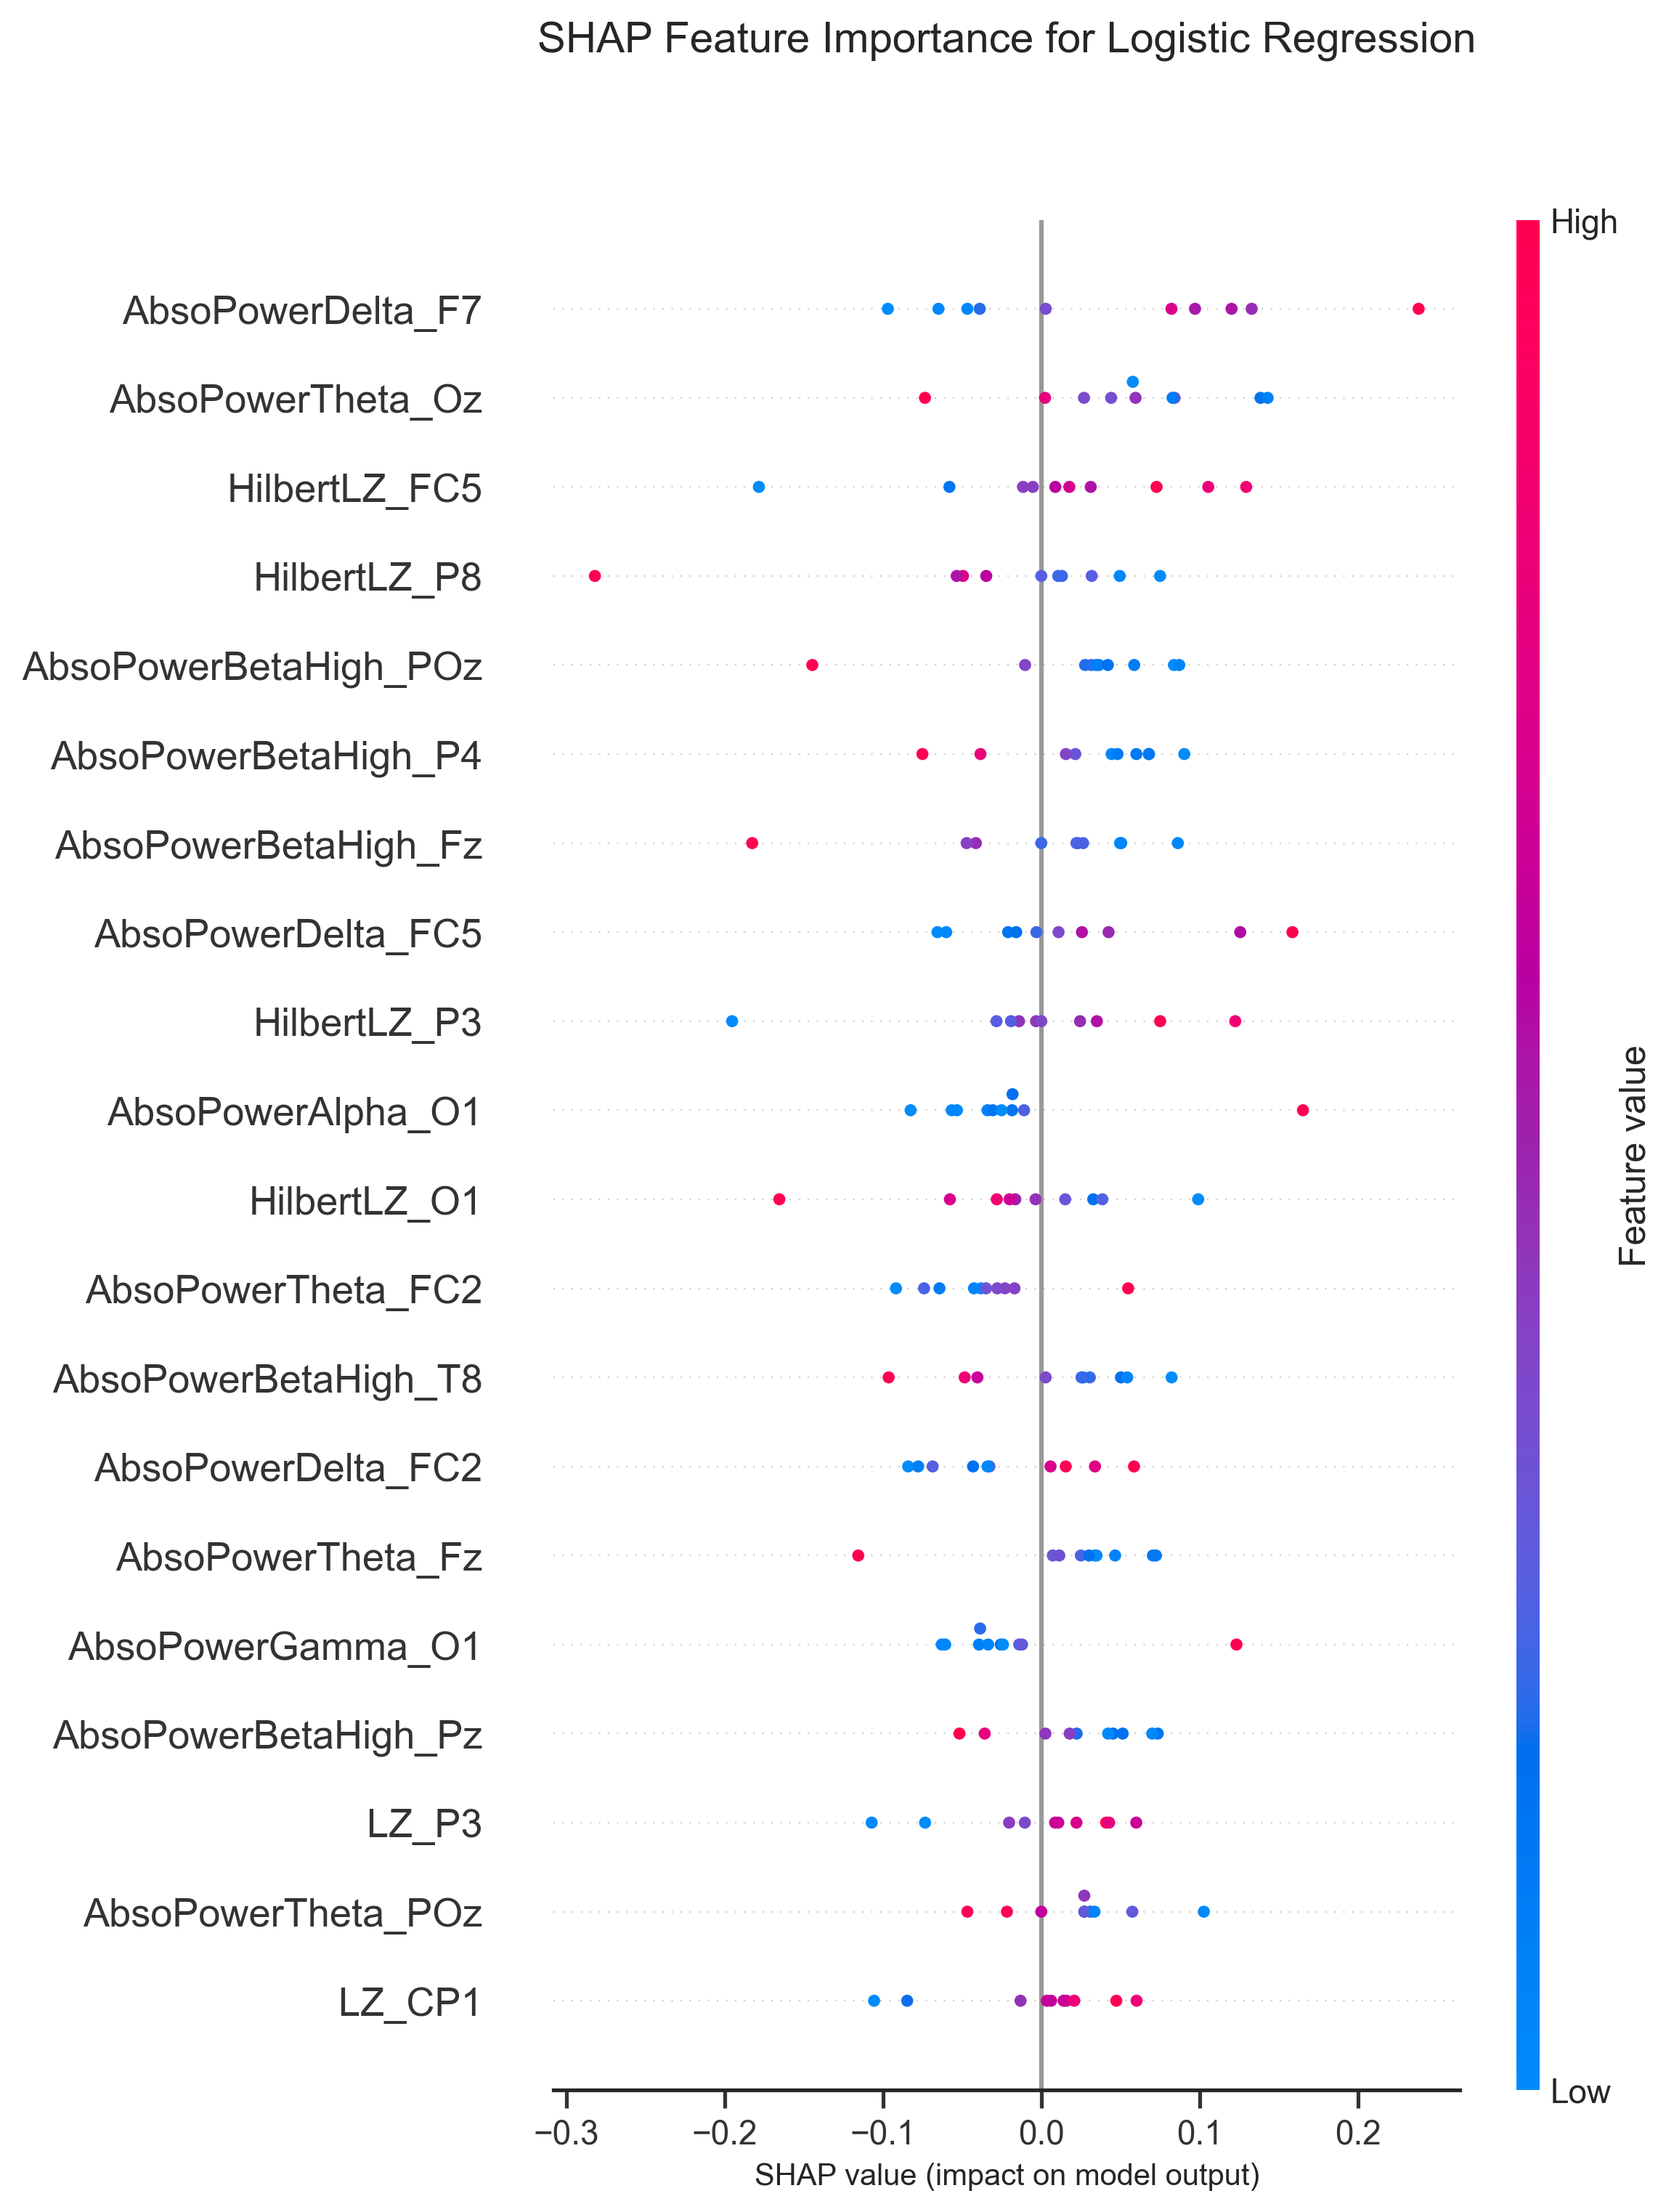

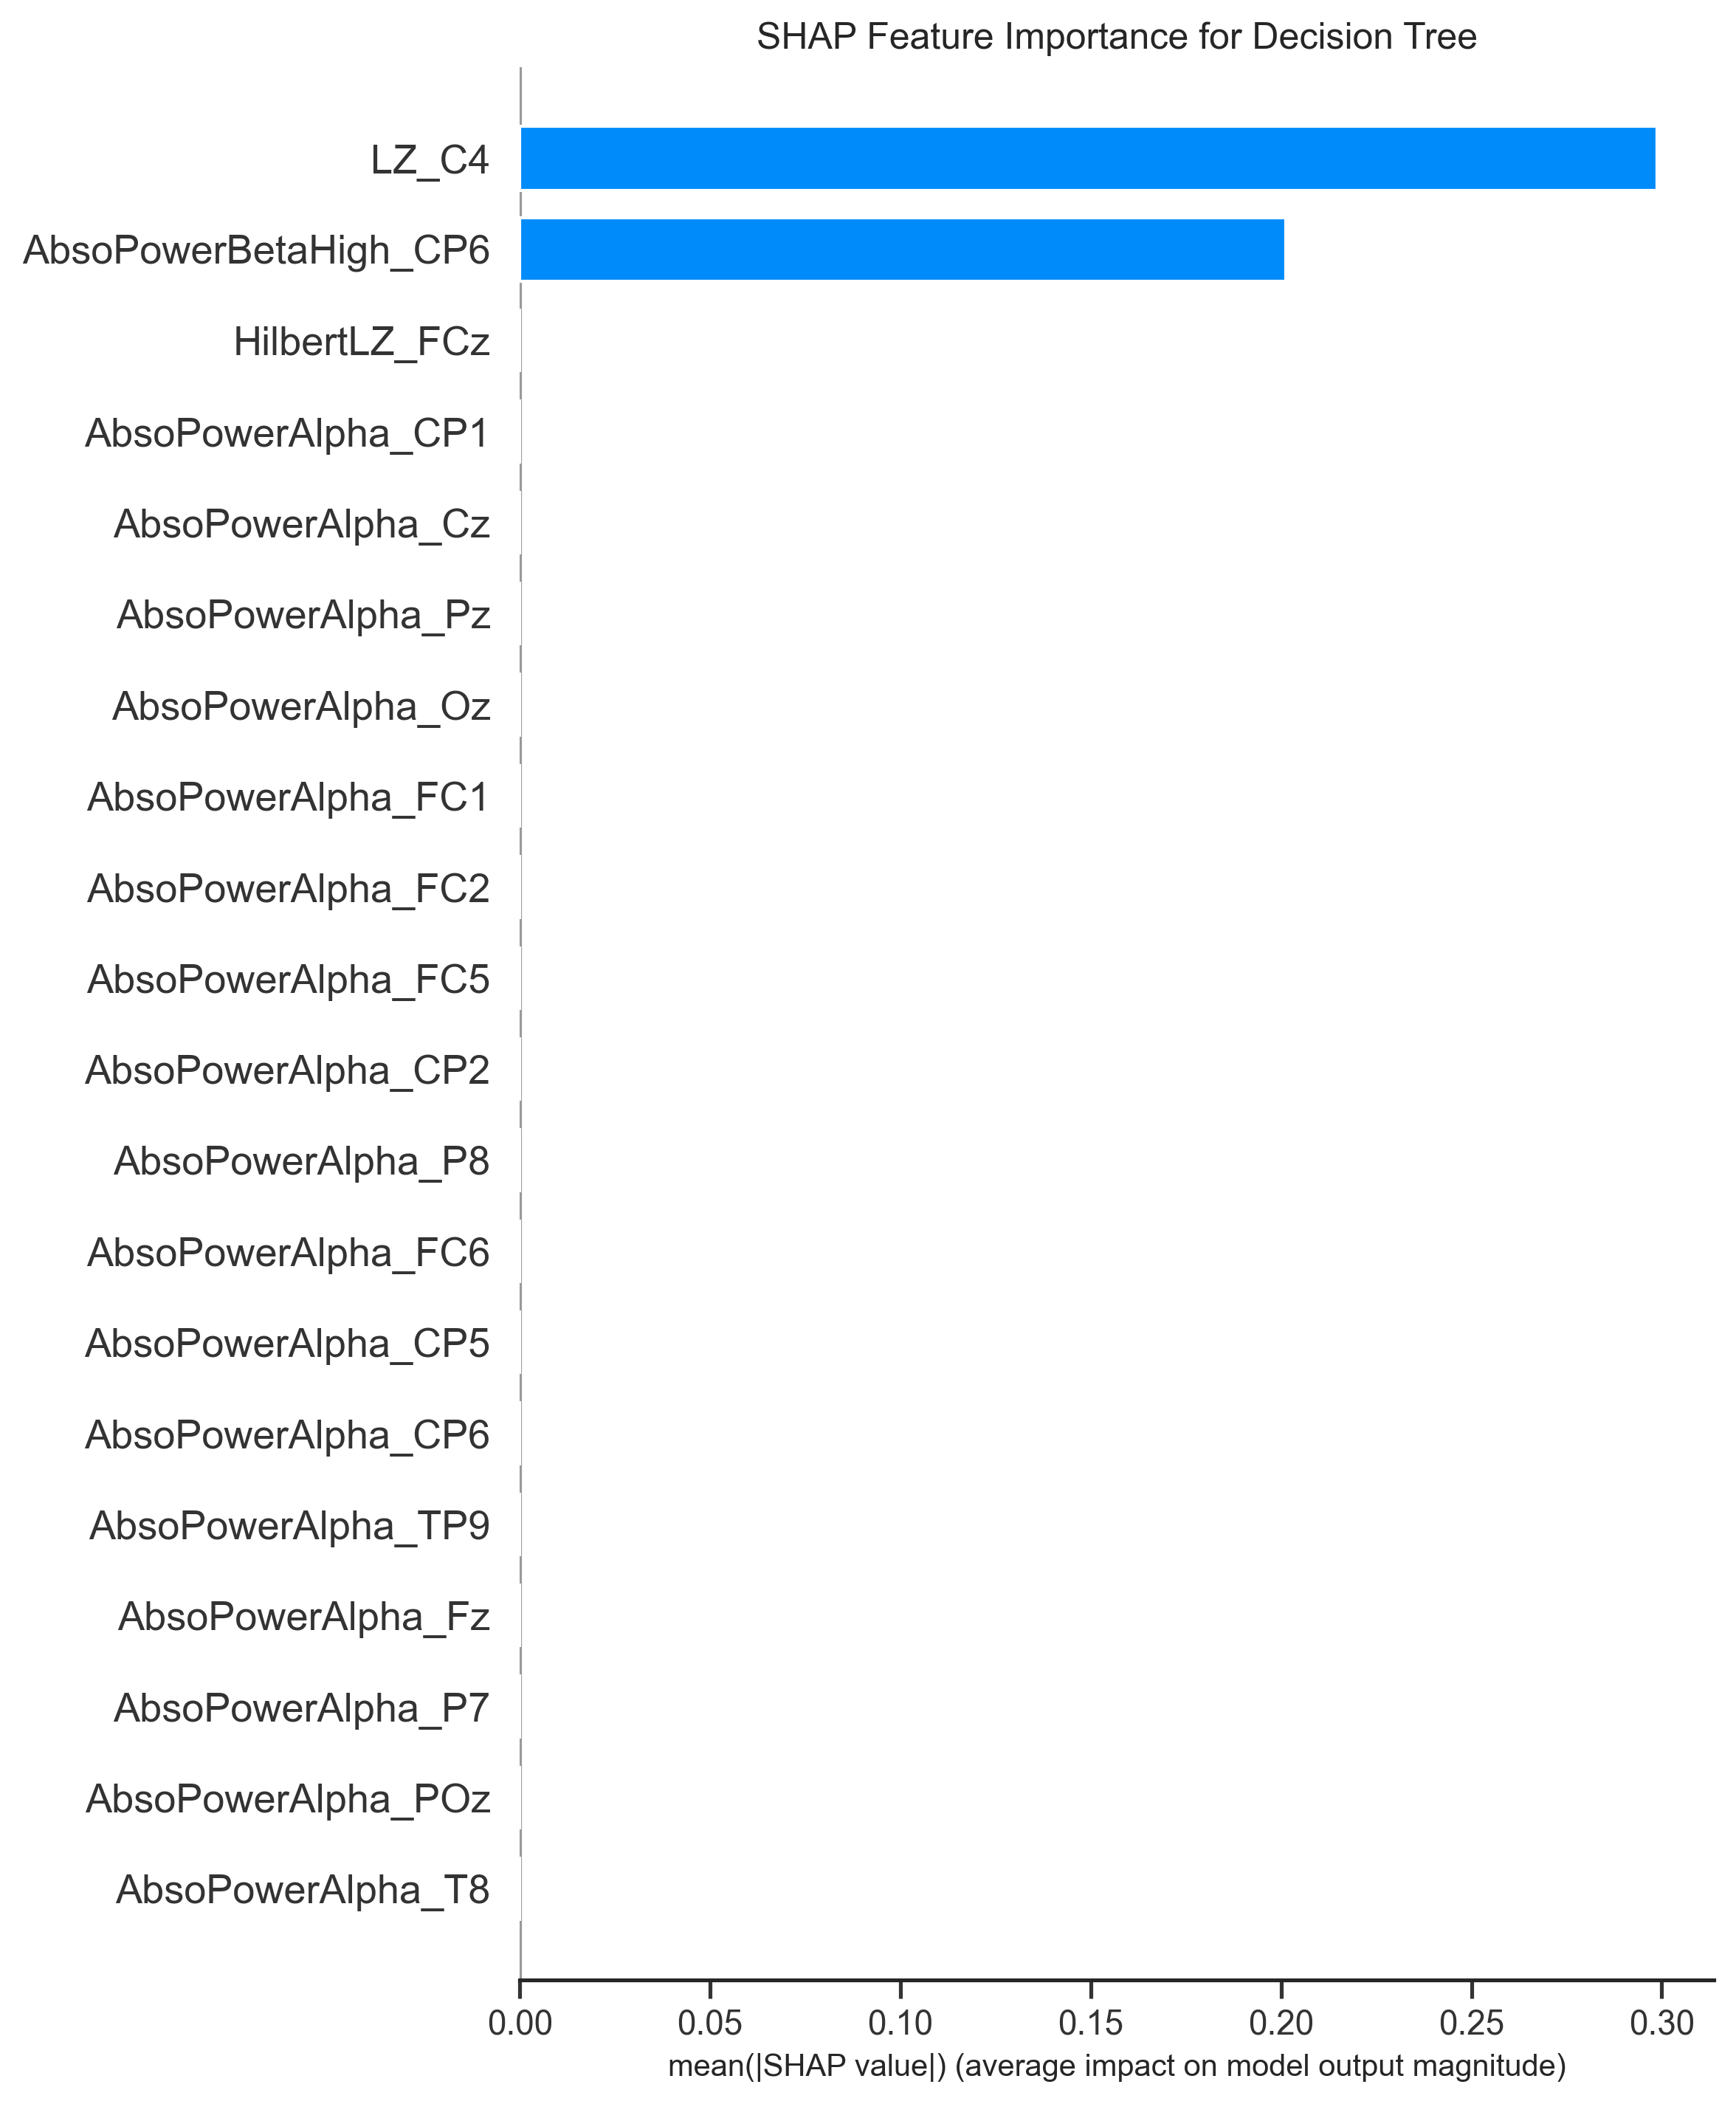

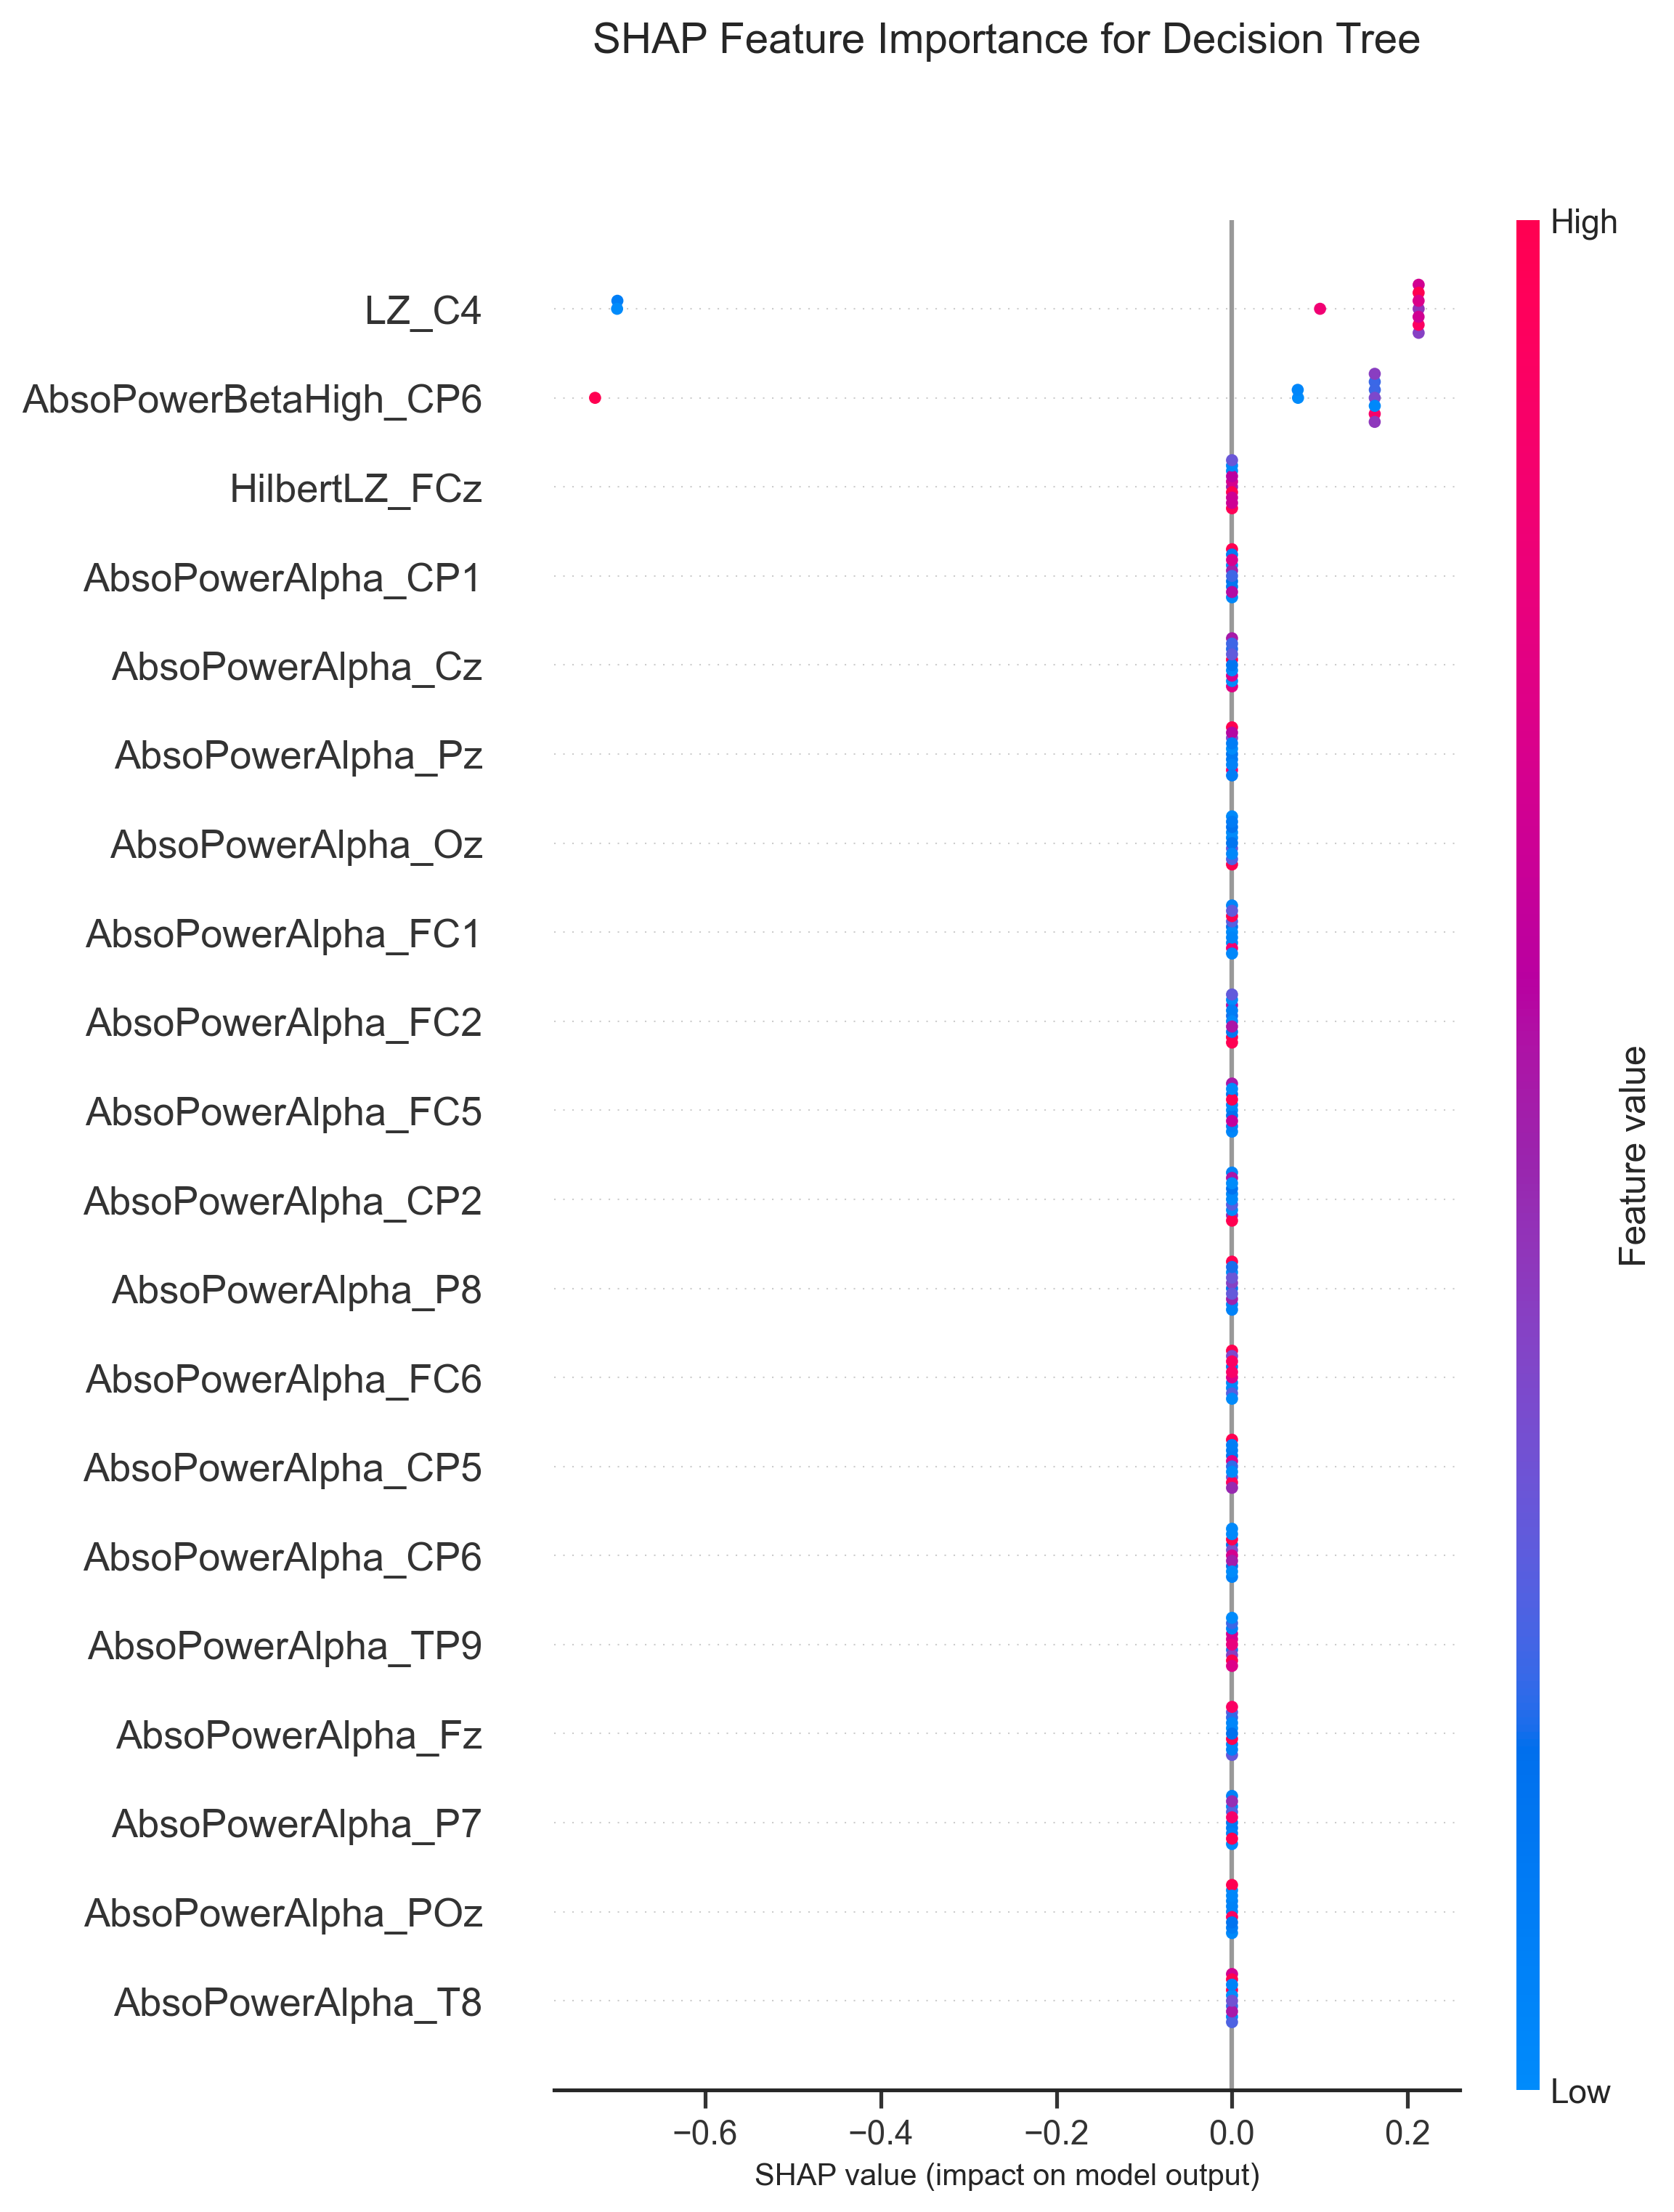

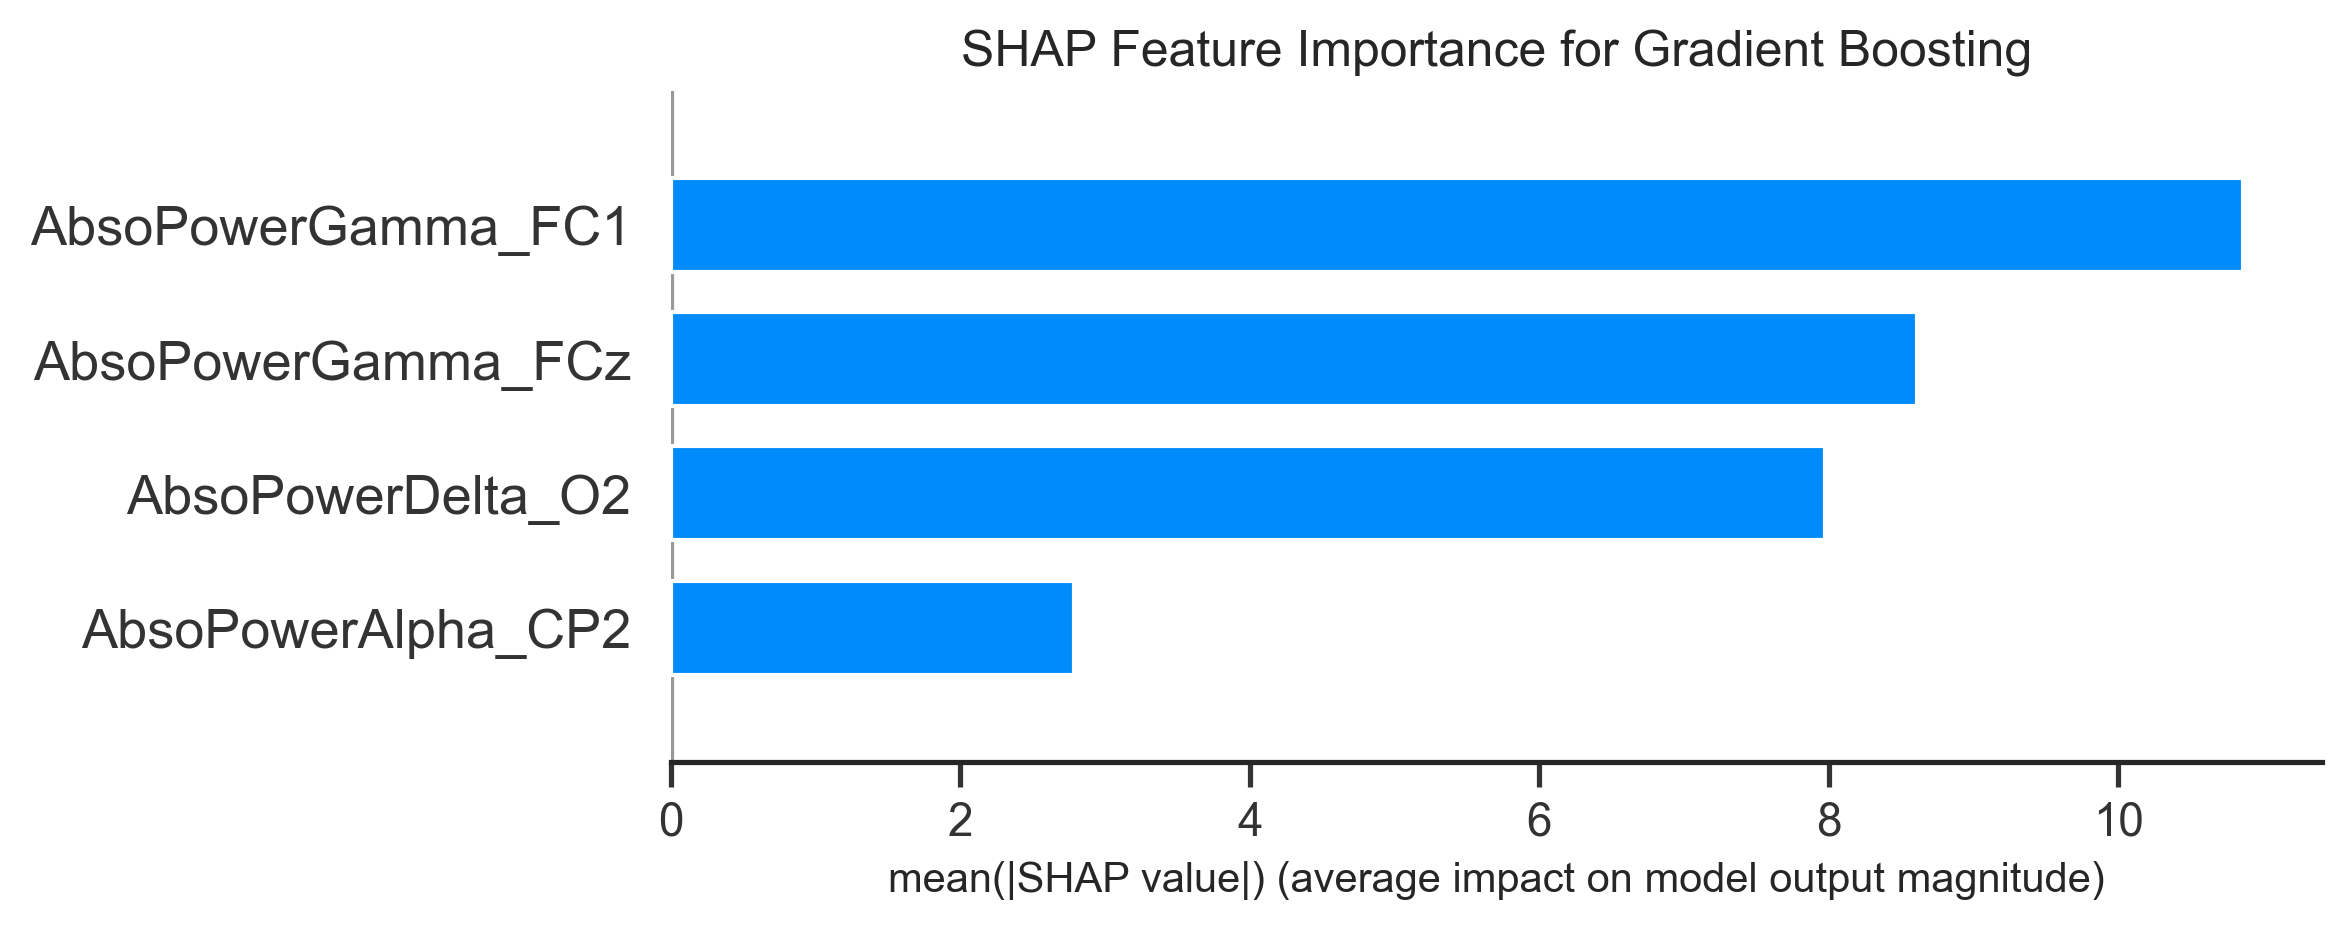

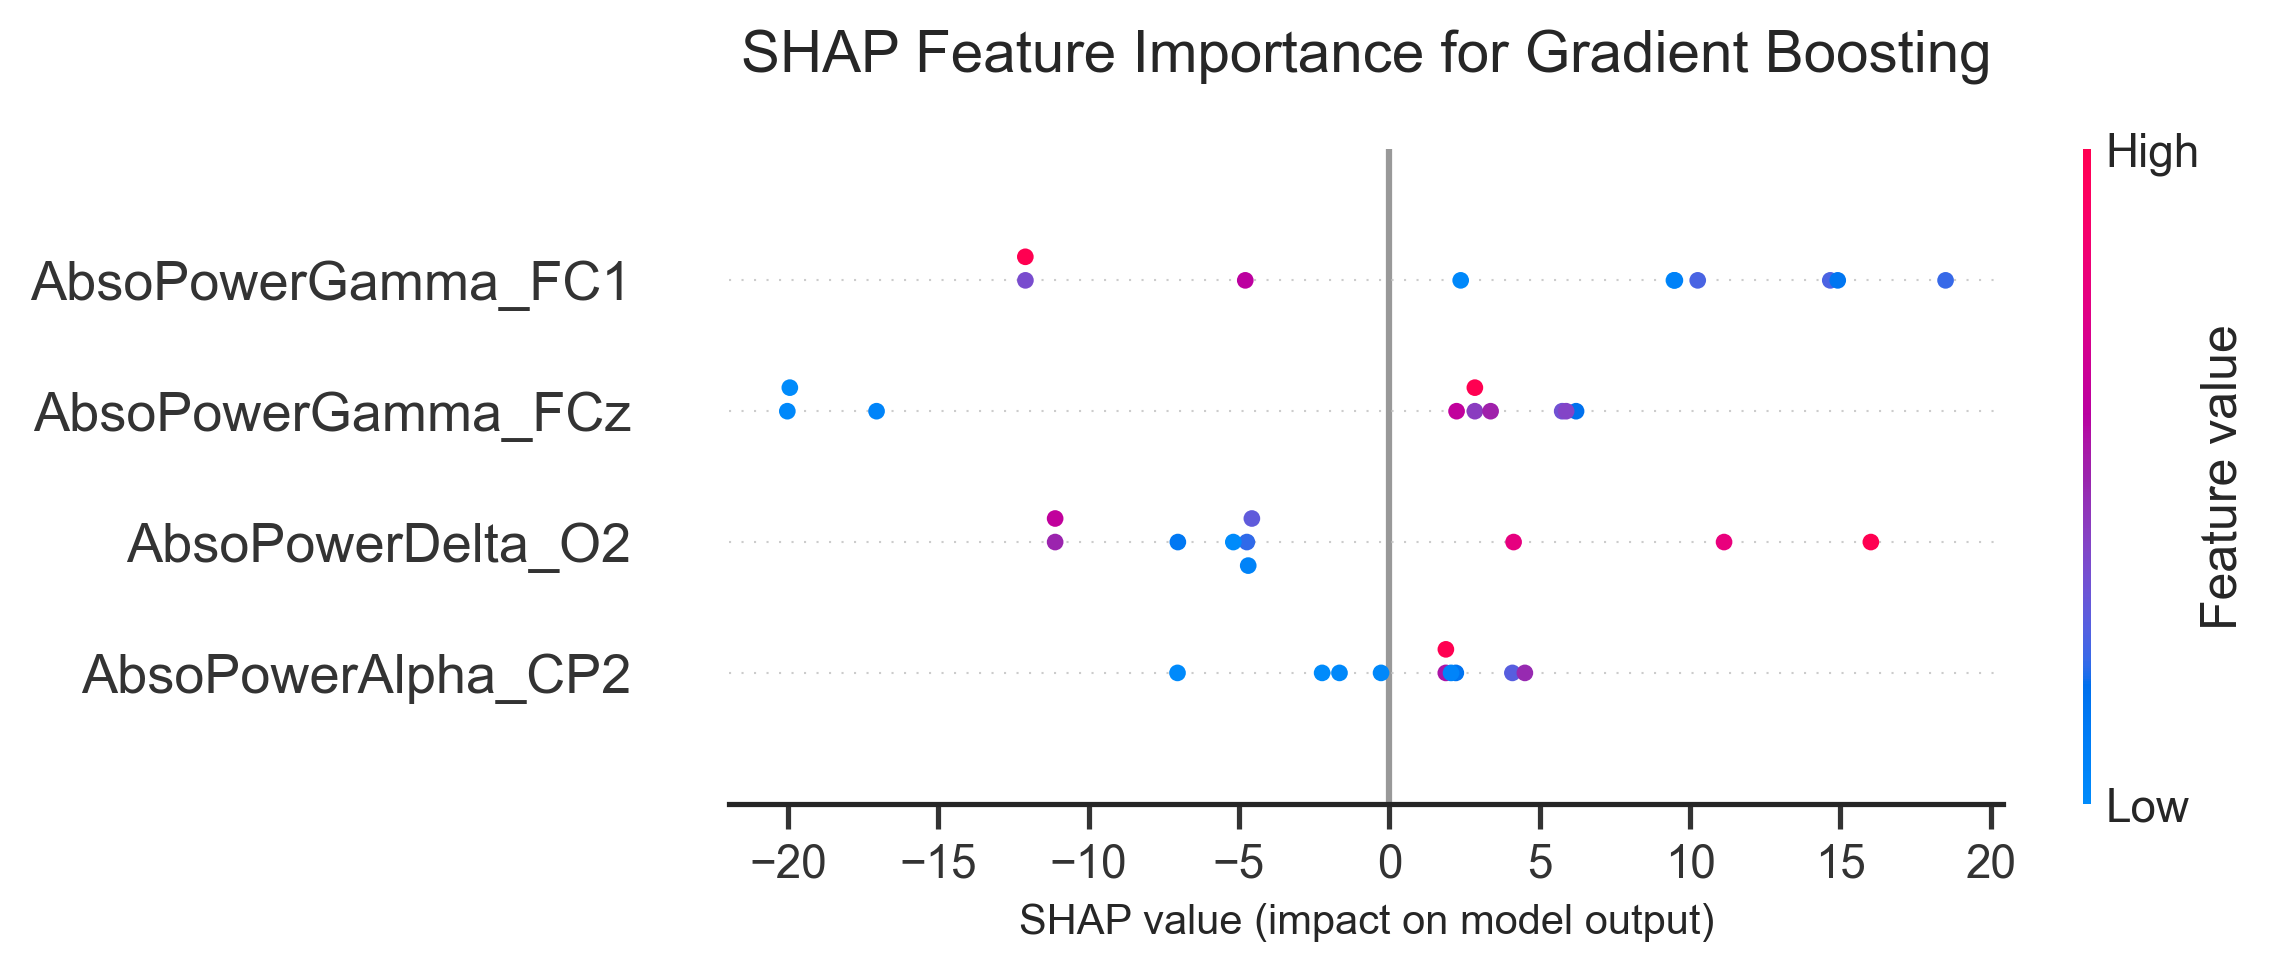

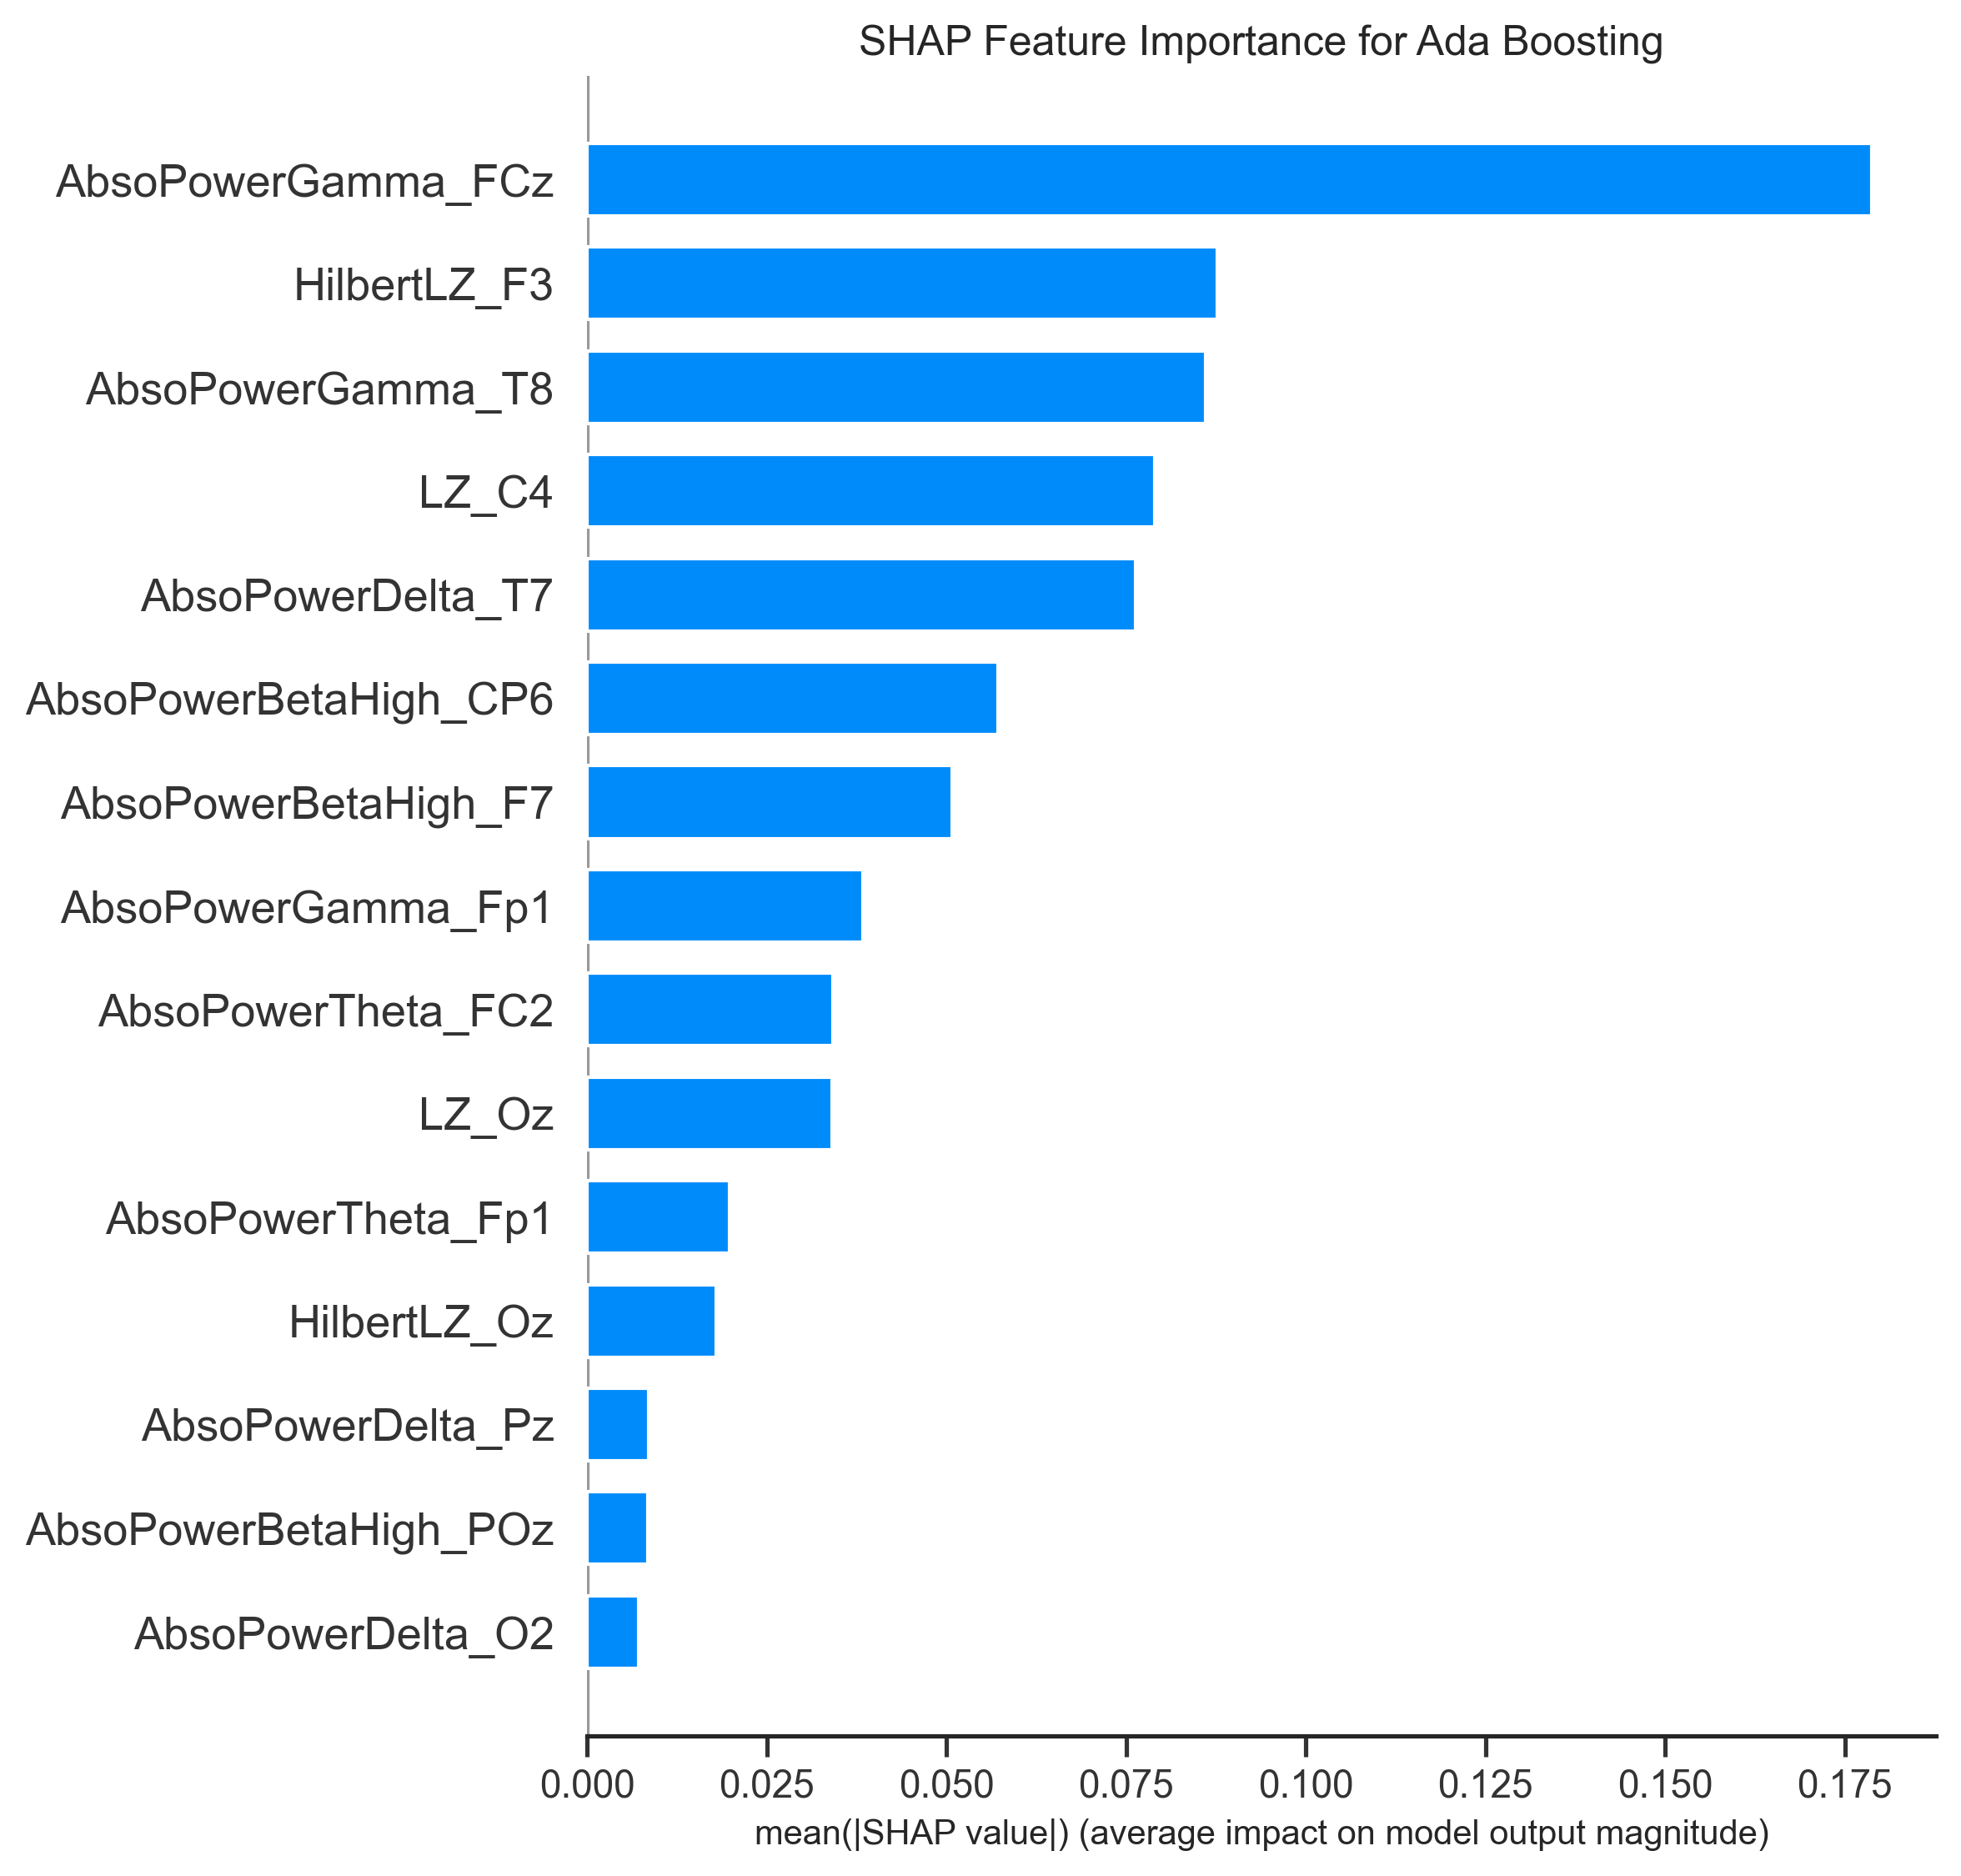

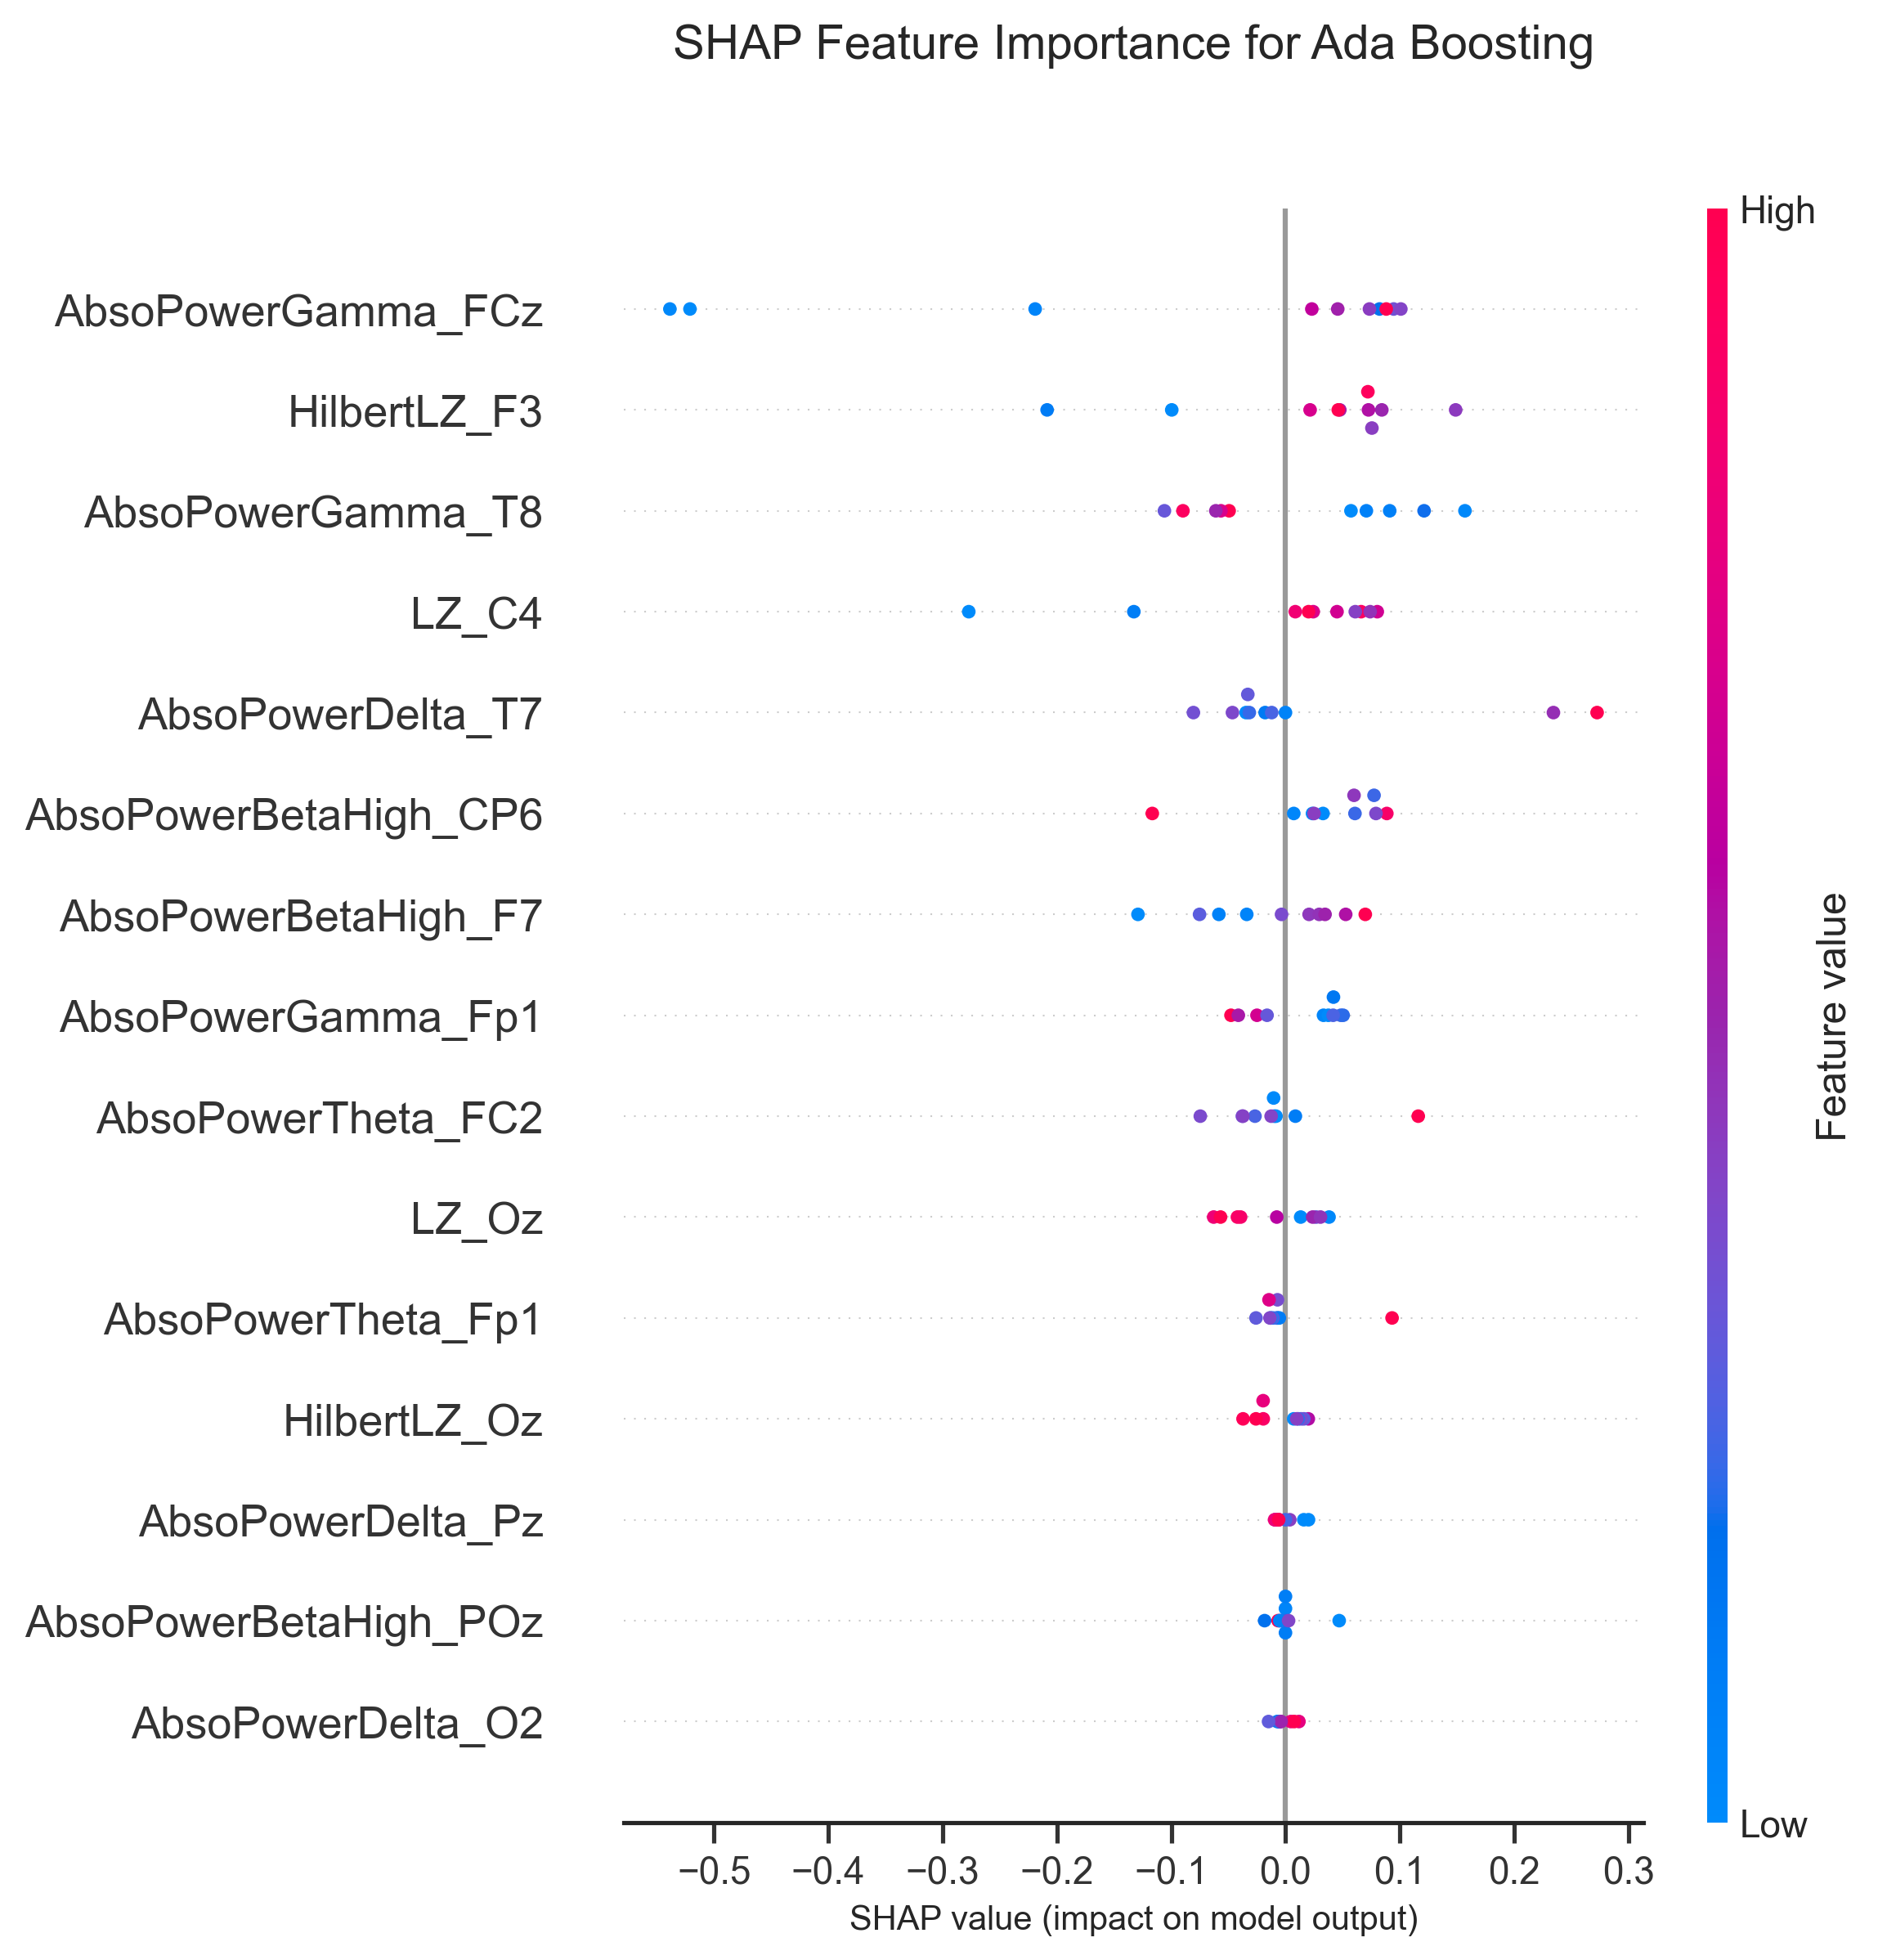

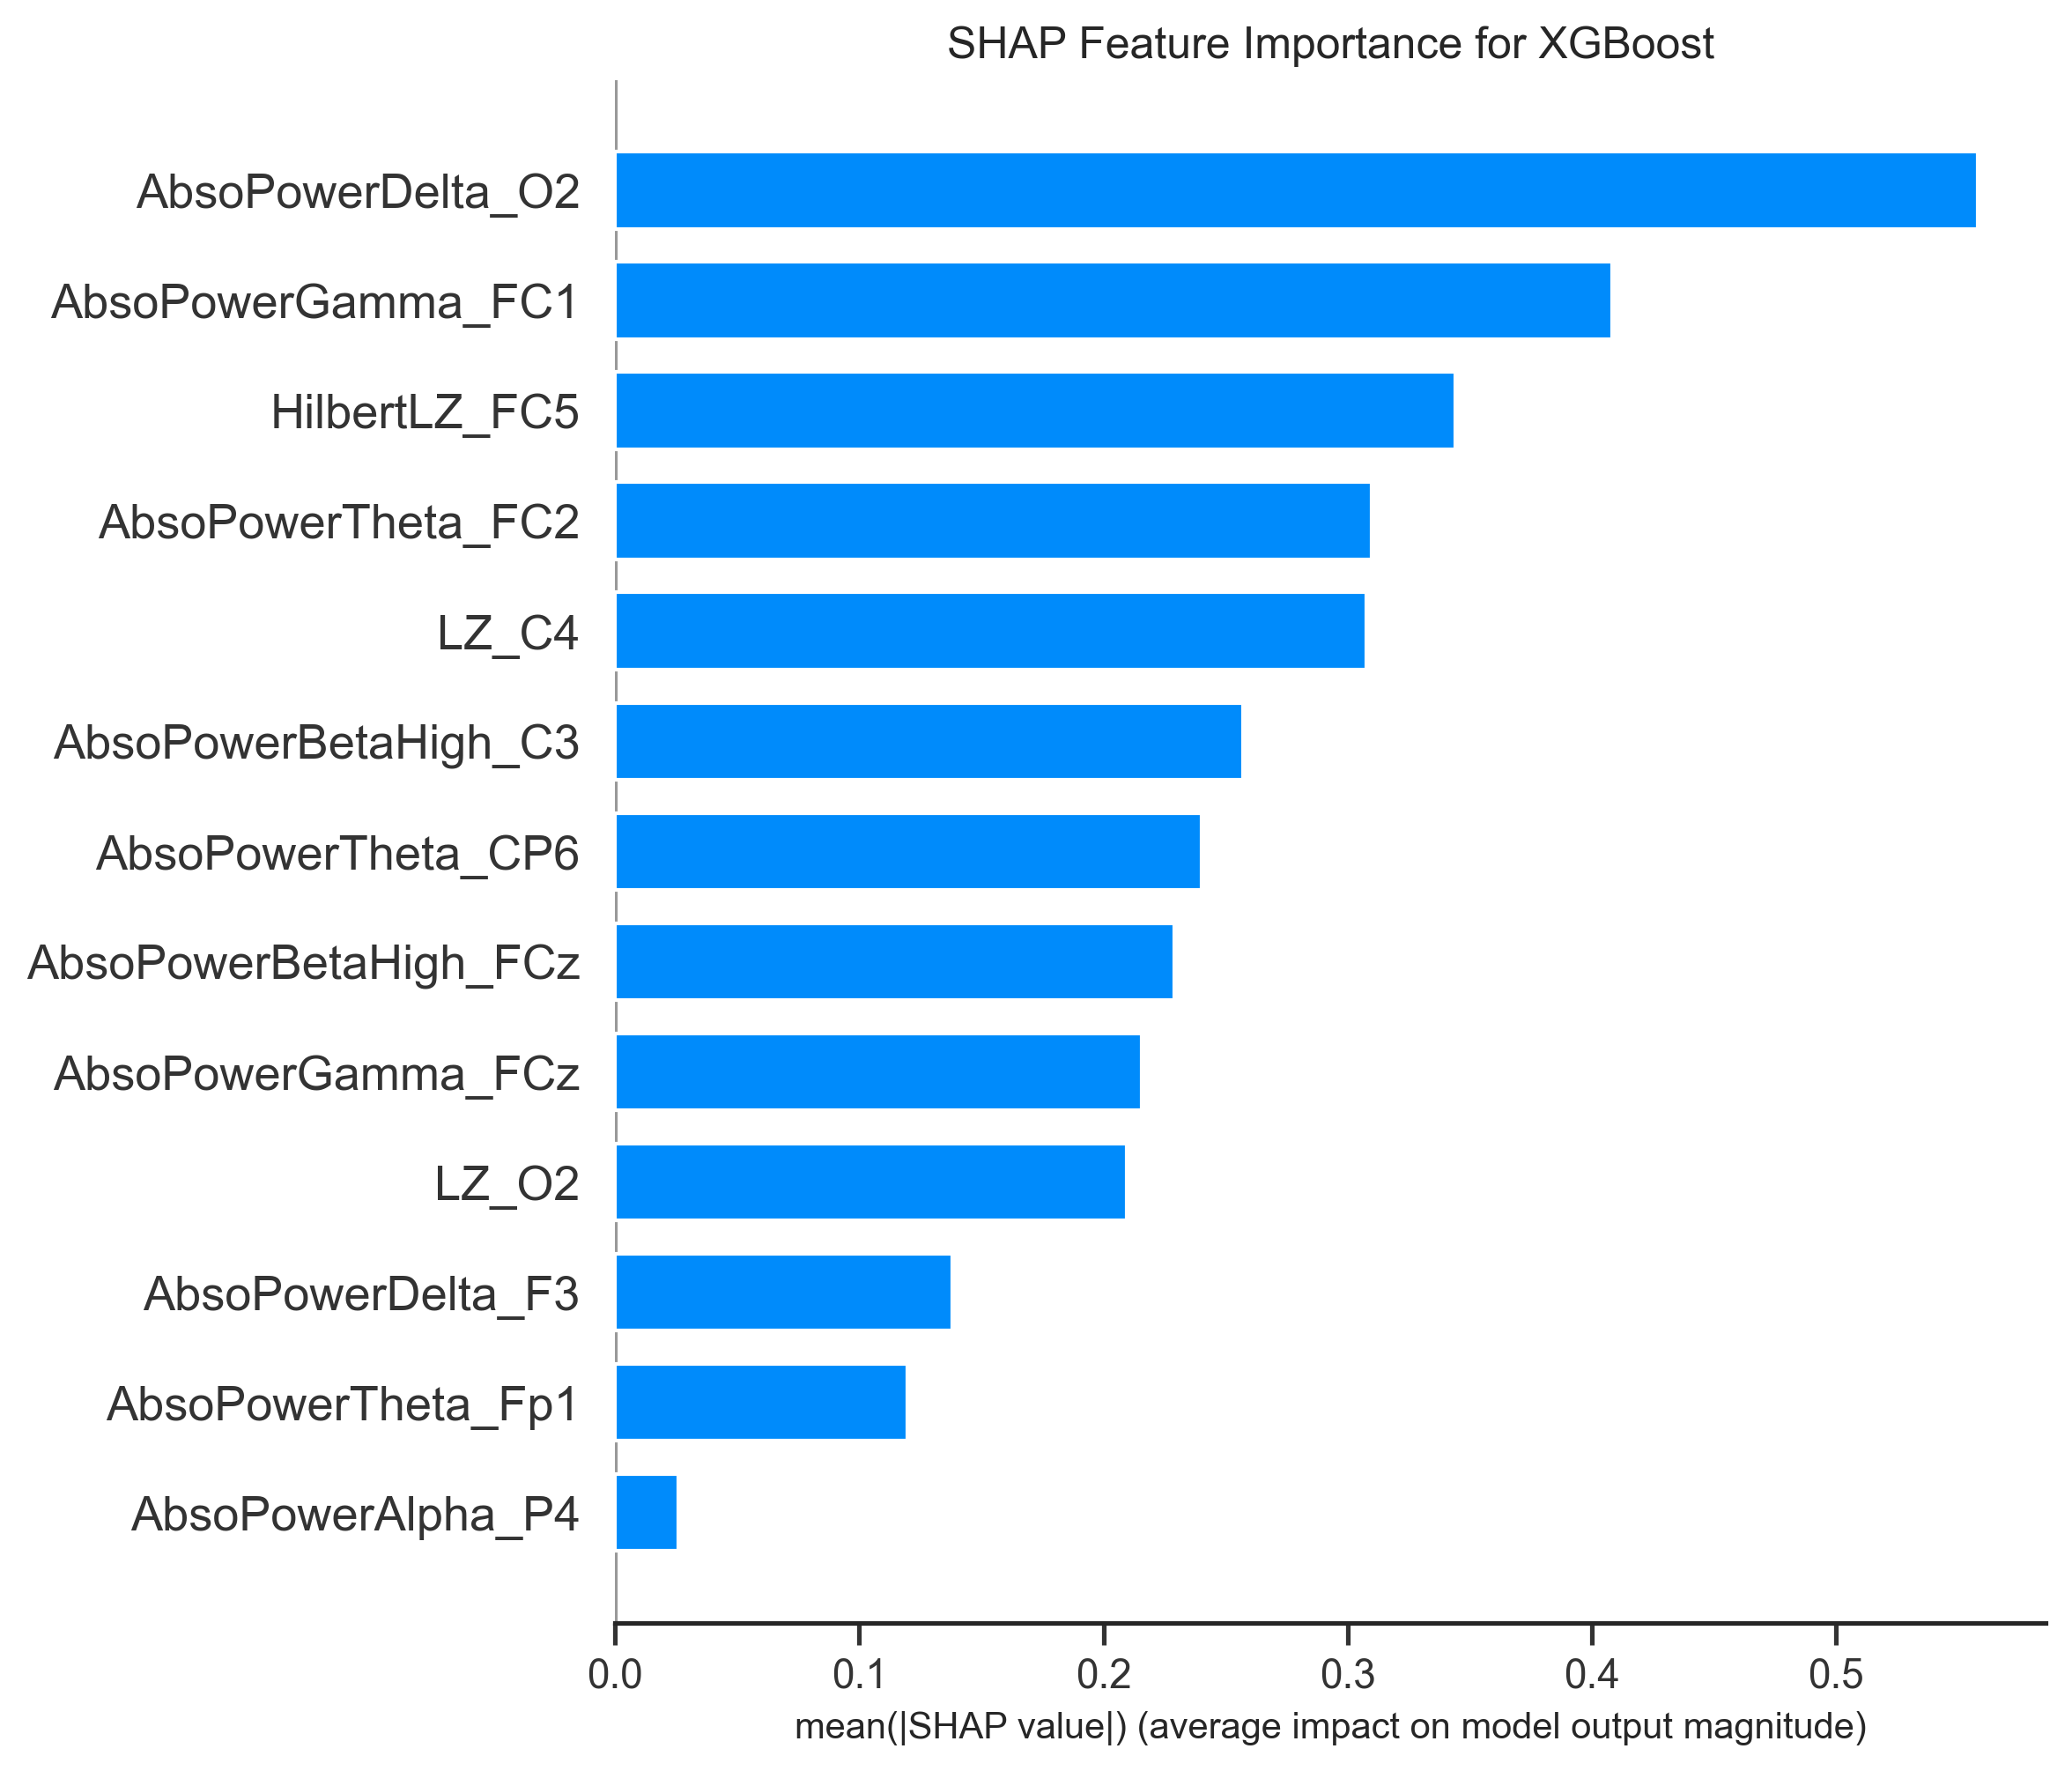

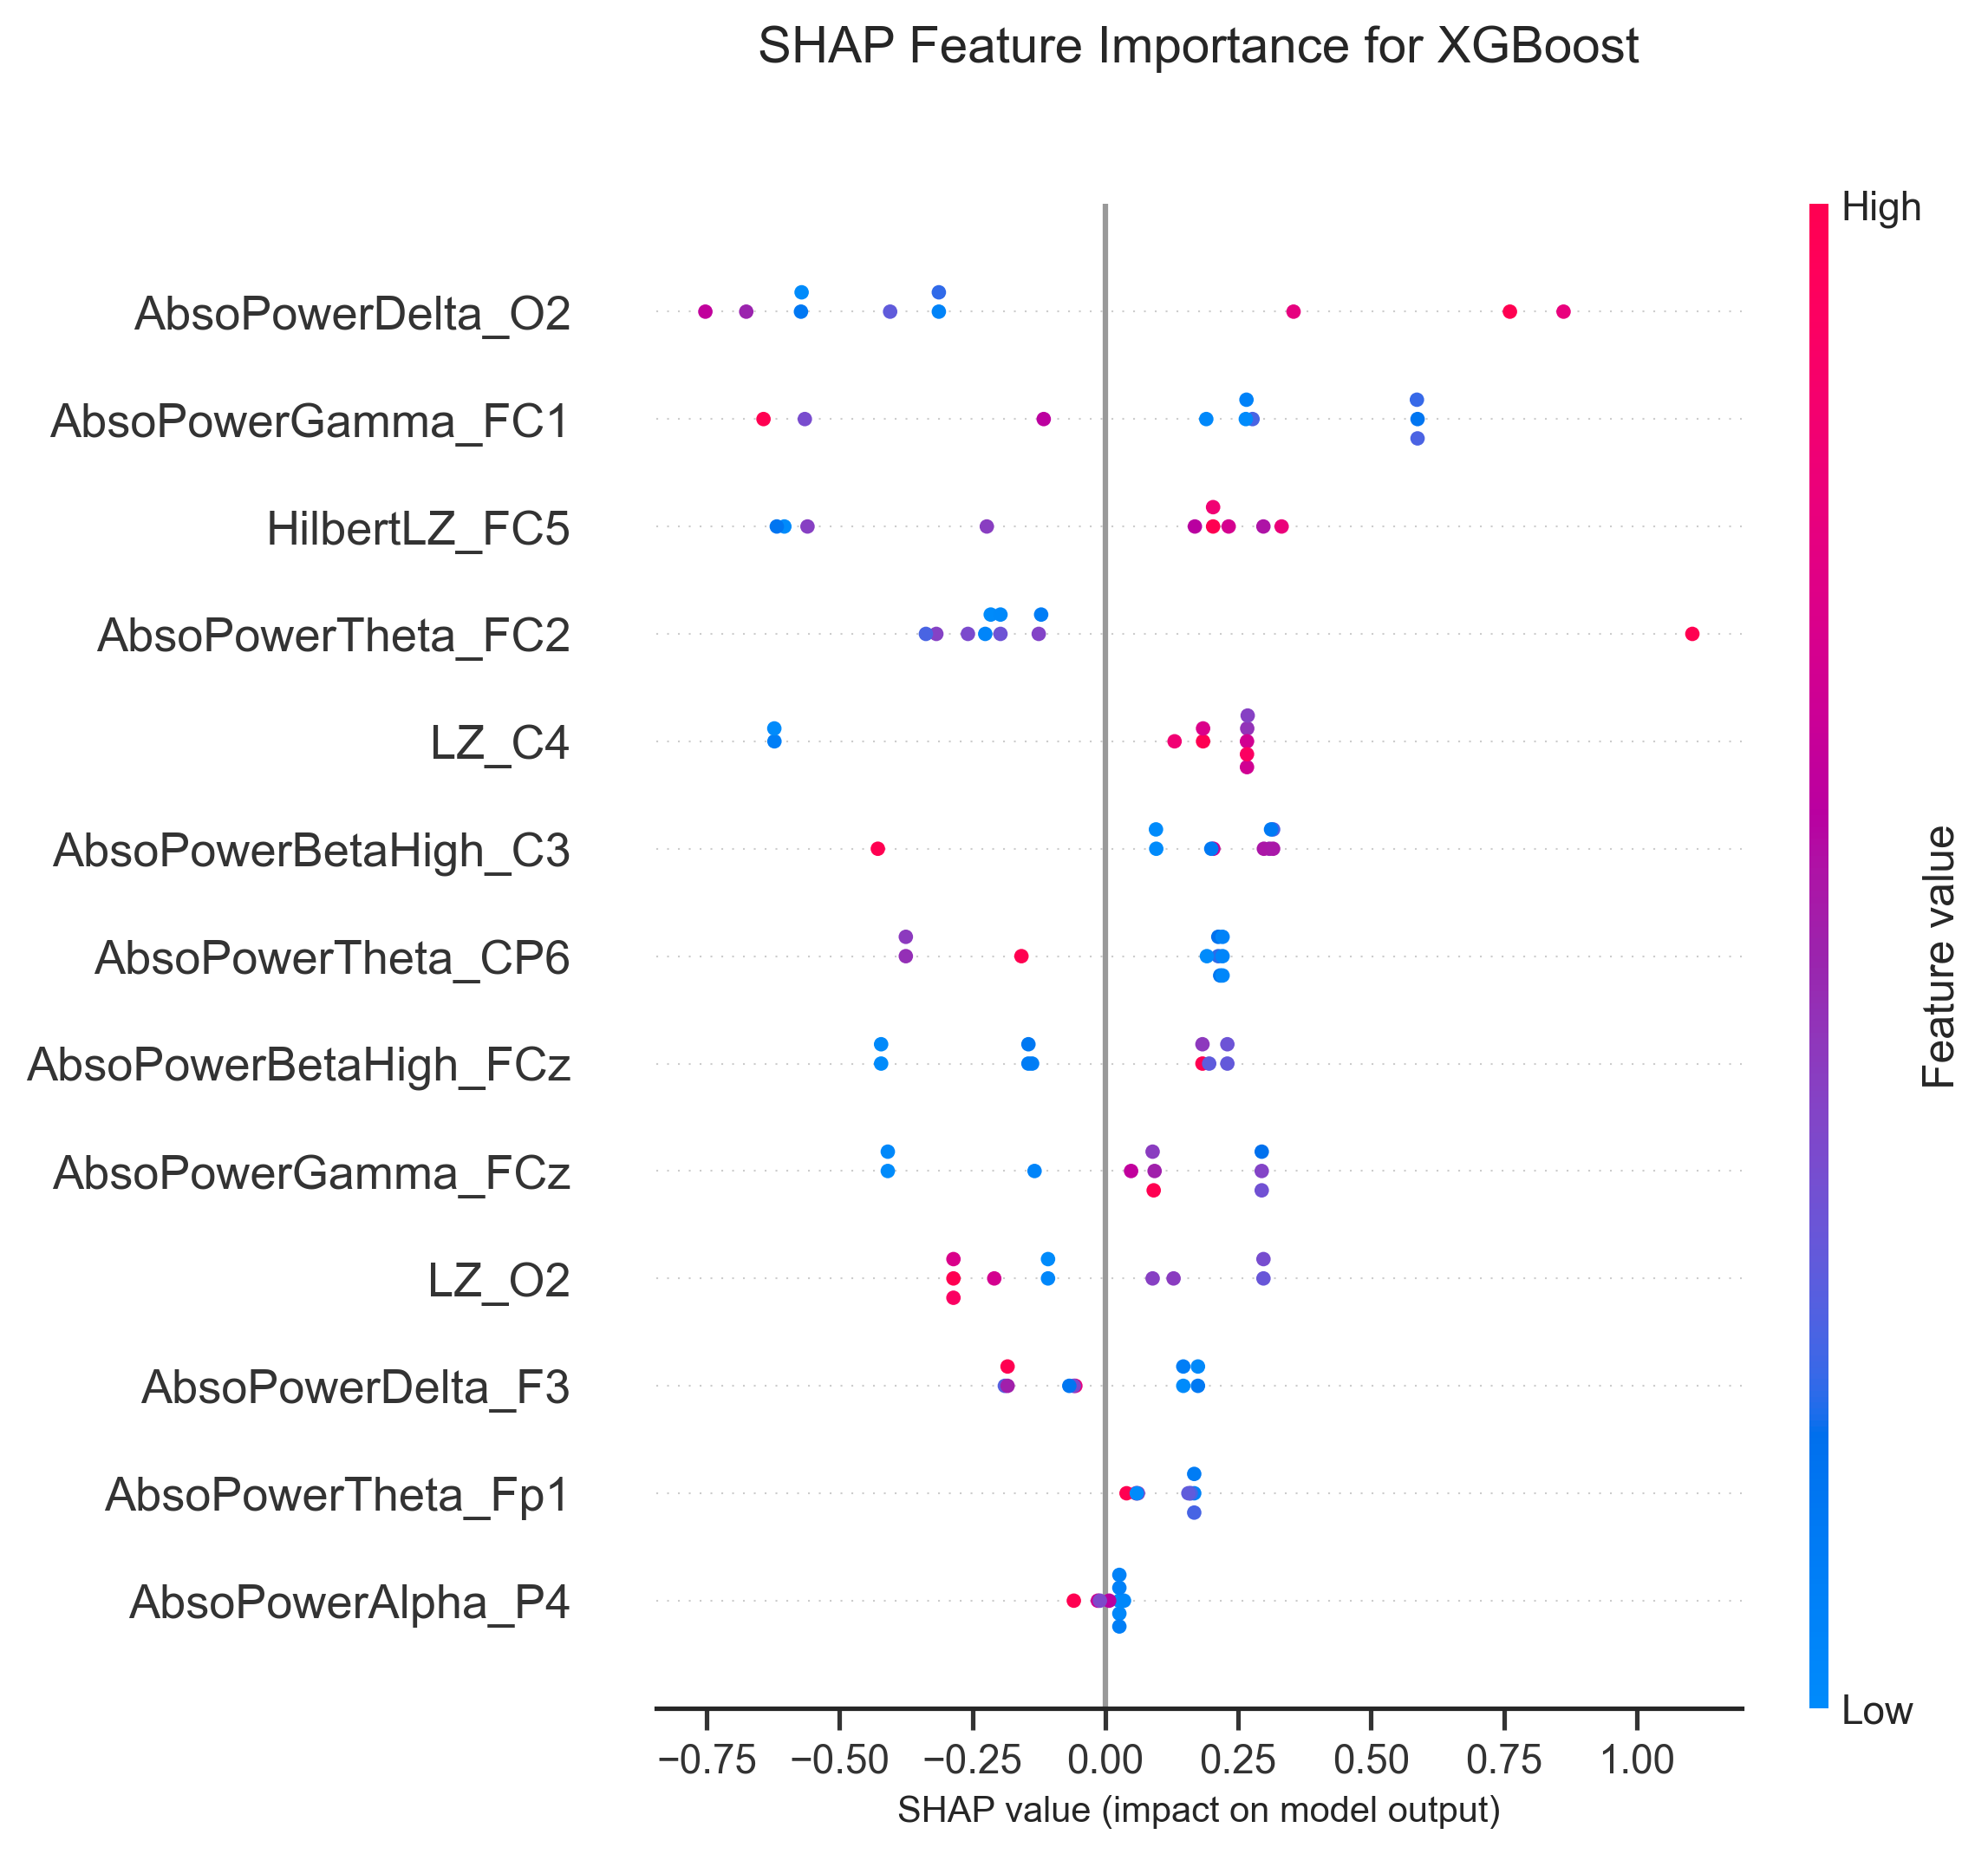

In [9]:
#Step 6: Feature importance - SHAP analysis and visualisation 
savedir = '/Users/millyadams/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Research Project/Data/PredictingExperiences_Paper/FollowUp_Paper/RESULTS/MYSTICAL/AbsoLZ/SHAP/'

sns.set(style="white") #change to white grid if want gird 

#Perform SHAP analysis on all models 
for name, model in best_models.items(): #for all models in best_models dictionary (saved in HPT) 

    X_train = rfe_data[name]['X_train_SF'] #extract X datasets with only selected features for that model 
    X_test = rfe_data[name]['X_test_SF']
    
    selected_features_for_model = selected_features[name] #identify selected features for model 
    
    # Debug print statements to verify data
    print(f"Model: {name}")
    print(f"Selected features: {selected_features_for_model}")
    print(f"X_train_rfe shape: {X_train.shape}")
    print(f"X_test_rfe shape: {X_test.shape}")
    
    # Ensure X_train_rfe and X_test_rfe are DataFrames - columns for selected features 
    X_train = pd.DataFrame(X_train, columns=selected_features_for_model)
    X_test = pd.DataFrame(X_test, columns=selected_features_for_model)
    
    shap_analysis(model, X_train, X_test, name, selected_features_for_model, savedir=savedir)
